In [1]:
import numpy as np
import os, shutil, glob, tempfile, gc
import math, random
from datetime import datetime
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

mos_img_dir = './datasets/Chula7MosDatasets/Mosquito_512/Mosquito_7class_512_aug/'
class_names = ['Aedes aegypti', 'Aedes albopictus', 'Aedes vexans', 'An tessellatus', 'Culex quinquefasciatus', 'Culex vishnui', 'Others']

NUM_EPOCH_PER_TRAIN = 40

BATCH_SIZE = 8

# initial value of learning rate
LR = 2e-5
# multiplier factor
LR_MULTIPLIER = 0.5
# number of epochs per reduction
NUM_EPOCH_PER_LR_UPDATE = 10

# original image size
IMG_SIZE = 224

# ratio of (train, val, test)
RATIO = (0.80, 0.2, 0) # train, val, test -> We don't need test = val

# Function to callback every beginning of each epoch
# Learning rate adaptation
def lr_scheduler(epoch, lr):
    return lr * LR_MULTIPLIER if (epoch % NUM_EPOCH_PER_LR_UPDATE) == 0 else lr

lr_adjust = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', baseline=0.2,  min_delta = 0.0001, 
                               patience=15, restore_best_weights = True)
run_no = 0
model_no = 0
acc = np.zeros((4,10))

2022-09-24 09:15:37.329806: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
print(tf.__version__)

2.9.1


In [3]:
def between0i1x(f):
    if 0 <= f < 1:
        return True
    else:
        return False
    

In [4]:
def RandomTrainValTest(src_dir, dst_dir, ratio = (0.8, 0.2, 0)):
    #check if Destination directory already exists
    if os.path.exists(dst_dir):
        print('Destination directory already exists. Do nothing!!!')
        return
    TRAIN_RATIO = round(ratio[0], 3)
    VAL_RATIO = round(ratio[1], 3)
    TEST_RATIO = round(1 - TRAIN_RATIO - VAL_RATIO, 3)
    if not between0i1x(TEST_RATIO) or not between0i1x(VAL_RATIO) or not between0i1x(TRAIN_RATIO):
        print('Ratio must be more than or equal 0 and less than 1.')
        return
    print('Ratio = (' + str(TRAIN_RATIO) +', ' + str(VAL_RATIO) + ', ' + str(TEST_RATIO) + ').' )
    if TEST_RATIO != round(ratio[2],3):
        print('Sum of ratio must be 1.')
        return
    
    # create a temp dir and copy all files recursively to temp_dir
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)
    # scan species, they must be immediatly under the src_dir 
    for species in os.scandir(src_dir):
        if not species.name.startswith('.') and species.is_dir():
            class_dir = tmp_dir + '/' + species.name
            print('Found ' + species.name)
            #calculate No. of files in each species 
            file_no = 0
            for entry2 in os.scandir(class_dir):
                if not entry2.name.startswith('.') and entry2.is_file():
                    file_no += 1
            print('No. of files in ' + species.name + ' = ' + str(file_no) + '.')
            # create subdirectories if necessary
            if not os.path.exists(dst_dir):
                os.mkdir(dst_dir)
            test_dir = dst_dir + '/test/' 
            val_dir = dst_dir + '/val/' 
            train_dir = dst_dir + '/train/' 
            if not os.path.exists(test_dir):
                os.mkdir(test_dir)
            if not os.path.exists(val_dir):
                os.mkdir(val_dir)
            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
            # create species.name dir    
            stest_dir = test_dir + species.name + '/'
            sval_dir = val_dir + species.name + '/'
            strain_dir = train_dir + species.name + '/'
            if not os.path.exists(stest_dir):
                os.mkdir(stest_dir)
            if not os.path.exists(sval_dir):
                os.mkdir(sval_dir)
            if not os.path.exists(strain_dir):
                os.mkdir(strain_dir)
            # calculate number of files for train, val, test    
            no_file_train = math.ceil(file_no*TRAIN_RATIO)
            no_file_val = math.ceil(file_no*VAL_RATIO)
            no_file_test = math.ceil(file_no*TEST_RATIO)
            
            # for training data
            file_no = 0
            while file_no < no_file_train : 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                #print(selectedFile)
                no = selectedFile.find('-') 
                SelectedFiles = selectedFile[0:no] + '*'
                if SelectedFiles[0].isdigit():
                    SelectedFiles = SelectedFiles[2:]
                SelectedFiles = '*' + SelectedFiles

                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ SelectedFiles, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + strain_dir + '" should be around ' + str(no_file_train) + '.')
            print('No. of files in ' +strain_dir + ' = ' + str(file_no) +'.' )
            
            # for test data
            file_no = 0
            while file_no < no_file_test and os.listdir(tmp_dir + '/' + species.name): 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                #print(selectedFile)
                no = selectedFile.find('-') 
                SelectedFiles = selectedFile[0:no] + '*'
                if SelectedFiles[0].isdigit():
                    SelectedFiles = SelectedFiles[2:]
                SelectedFiles = '*' + SelectedFiles
                
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ SelectedFiles, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + stest_dir + '" should be around ' + str(no_file_test) + '.')
            print('No. of files in ' +stest_dir + ' = ' + str(file_no) +'.' )
            #move all remaining files to val_dir
            SelectedFiles = '*'
            file_moved = 0
            for file in glob.iglob(class_dir +'/'+ SelectedFiles, recursive=True):    
                file_name = os.path.basename(file)
                shutil.move(file, sval_dir + file_name)
                file_moved += 1
            file_no = file_moved    
            print('No. of files in "' + sval_dir + '" should be around ' + str(no_file_val) + '.')
            print('No. of files in ' +sval_dir + ' = ' + str(file_no) +'.' )
                

In [5]:
def SplitLeftRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # half of it
                half_file_no = math.floor(file_no/2)
                print('There should be ' + str(half_file_no)  + ' files in DST_DIR/[LEFT,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:half_file_no]
                FileListR = FileList[half_file_no:half_file_no*2]
                files_in_train_val_test[subidx] += half_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])

def SplitLeftMiddleRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    MIDDLE = '/Middle/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + MIDDLE)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_middle_sub = dst_dir + MIDDLE + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_middle_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # third of it
                third_file_no = math.floor(file_no/3)
                print('There should be ' + str(third_file_no)  + ' files in DST_DIR/[LEFT,MIDDLE,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:third_file_no]
                FileListM = FileList[third_file_no:third_file_no*2]
                FileListR = FileList[third_file_no*2:third_file_no*3]
                files_in_train_val_test[subidx] += third_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_middle_sub_species = dst_middle_sub + '/' + species.name
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_middle_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListM:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_middle_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])
 

In [6]:
def randomSplitMosData(input_dir, output_dirLR, output_dirLMR, ratio = (0.8, 0.2, 0)):
    tmpX = tempfile.TemporaryDirectory().name
    RandomTrainValTest(input_dir,tmpX, ratio = ratio)
    #tmpX = '/tmp/tmpk_mjnf4g'
    no_files_LR = SplitLeftRight(tmpX, output_dirLR)
    no_files_LMR = SplitLeftMiddleRight(tmpX, output_dirLMR)
    return no_files_LR, no_files_LMR    

In [7]:
def read_ds(src_dir):
    
    train_dir = src_dir  + '/Left/train'
    train_dir1 = src_dir + '/Right/train'
    val_dir = src_dir    + '/Left/val'
    val_dir1 = src_dir   + '/Right/val'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      image_size=(IMG_SIZE, IMG_SIZE),
      shuffle = False,
      label_mode='categorical',
      batch_size=BATCH_SIZE)

    val_ds = tf.keras.utils.image_dataset_from_directory(
      val_dir,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)



    train_ds1 = tf.keras.utils.image_dataset_from_directory(
      train_dir1,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)

    val_ds1 = tf.keras.utils.image_dataset_from_directory(
      val_dir1,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1)



In [8]:
def combineDS(train_ds, val_ds, train_ds1, val_ds1):
    train_num_batch = sum(1 for _ in train_ds)
    val_num_batch = sum(1 for _ in val_ds)

    # Normalize to (0-1)
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y))
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y))


    # split X & Y
    train_ds_X = train_ds.map(lambda x,y:(x))
    train_ds_Y = train_ds.map(lambda x,y:(y))
    train_ds_X1 = train_ds1.map(lambda x,y:(x))
    train_ds_Y1 = train_ds1.map(lambda x,y:(y))
    val_ds_X = val_ds.map(lambda x,y:(x))
    val_ds_Y = val_ds.map(lambda x,y:(y))
    val_ds_X1 = val_ds1.map(lambda x,y:(x))
    val_ds_Y1 = val_ds1.map(lambda x,y:(y))

    # Combine LEFT,RIGHT
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))


    # put back the label
    train_ds_X_X1_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    val_ds_X_X1_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))

    # Load the dataset onto GPU RAM for superspeed
    train_ds_X_X1_Y = train_ds_X_X1_Y.cache()
    val_ds_X_X1_Y = val_ds_X_X1_Y.cache()

    # reshuffle the train ds every batch (second times onwords in GPU), but shuffle val ds only once
    train_ds_X_X1_Y = train_ds_X_X1_Y.shuffle(train_num_batch, reshuffle_each_iteration=True)
    val_ds_X_X1_Y = val_ds_X_X1_Y.shuffle(val_num_batch, reshuffle_each_iteration=False)

    # don't train all the dataset
    #train_ds_X_X1_Y = train_ds_X_X1_Y.take(np.ceil(train_ratio * train_num_batch))

    # prefetch the datasets for lower latency
    train_ds_X_X1_Y = train_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)
    val_ds_X_X1_Y = val_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)

    return (train_ds_X_X1_Y, val_ds_X_X1_Y)
    #...

In [9]:
from keras import initializers, Input, layers
# from tensorflow.keras.utils import Sequence
# from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Conv2D, Concatenate, Dropout, SpatialDropout2D, SpatialDropout1D, MaxPool2D, Add
def custom_layer4Early(tensors):
    tensor1, tensor2 = tensors
    list1 = [224, 224]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Middle(tensors):
    tensor1, tensor2 = tensors
    list1 = [56, 56]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Late(tensors):
    tensor1, tensor2 = tensors
    list1 = [14, 14]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def buildEarlyModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0)
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Early, name='lambda_layer2')([block1_conv2,block1_conv2_1])

    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_1 = SpatialDropout2D(0)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildMiddleModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Middle, name='lambda_layer2')([block3_conv3,block3_conv3_1])

    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_3 = SpatialDropout2D(0)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildLateModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)
    maxpool_3_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3_1)
    spa_3_1 = SpatialDropout2D(0.2)(maxpool_3_1)
    block4_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3_1)
    block4_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1_1)
    block4_conv3_1 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2_1)
    maxpool_4_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3_1)
    spa_4_1 = SpatialDropout2D(0.2)(maxpool_4_1)
    block5_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4_1)
    block5_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1_1)
    block5_conv3_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Late, name='lambda_layer2')([block5_conv3,block5_conv3_1])
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)

    flat = Flatten()(maxpool_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

In [10]:
def loadVGG16ImageNetWeightsEarly(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2': 
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[9].set_weights(layer.get_weights()) 
        elif layer.name == 'block2_conv2': 
            model.layers[10].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[14].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[15].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[18].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[20].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[24].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[25].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[31].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsMiddle(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[27].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[28].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[32].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[34].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[38].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[40].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsLate(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[28].set_weights(layer.get_weights()),
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[30].set_weights(layer.get_weights()),
            model.layers[31].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[32].set_weights(layer.get_weights()),
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[38].set_weights(layer.get_weights()),
            model.layers[39].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[40].set_weights(layer.get_weights()),
            model.layers[41].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[42].set_weights(layer.get_weights()),
            model.layers[43].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[47].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[49].set_weights(layer.get_weights())
    return model



In [11]:
def compileModel(model):
    # Optimizer hyperparameter
    myAdam = keras.optimizers.Adam(
        learning_rate=LR/LR_MULTIPLIER,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=0.0001,
        amsgrad=True,
        name="Adam",)

    model.compile(optimizer=myAdam,
              loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    reduction="auto",
                    name="categorical_crossentropy"),
              metrics=['accuracy'])
    return model



In [12]:
def fitModel(model, train_ds, val_ds, lr_adjust = None, early_stopping = None):
    print('Start fitting from ' + datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    fitHistory = model.fit(train_ds,    
                  epochs=NUM_EPOCH_PER_TRAIN,   
                  validation_data = val_ds,
                  callbacks=[lr_adjust, early_stopping])
    print('End fitting at '+ datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    global acc, model_no, run_no
    acc[model_no, run_no] = np.max(fitHistory.history['val_accuracy'])
    model_no += 1
    return fitHistory


In [13]:
def plotAccuracyLoss(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    #epochs_range = range(epochs)
    epochs_range = range(len(loss))
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [14]:
def printConfusionMatrix(model, ds):
    #Confution Matrix and Classification Report

    Y_pred = model.predict(ds)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_true = np.concatenate([y for x, y in ds], axis=0)
    y_true = np.argmax(Y_true, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(y_true, y_pred))
    print('')
    print('')
    print('Classification Report')

    print(classification_report(y_true, y_pred, target_names=class_names))


In [15]:
def saveEarlyModel(model):
    path = './models/Model_Early_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    
def saveMiddleModel(model):
    path = './models/Model_Middle_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path

def saveLateModel(model):
    path = './models/Model_Late_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    

In [16]:
def read_dsLMR(LMR_dir):
    tmp_dir = LMR_dir
    tmp_dirL    = tmp_dir + '/Left/'
    tmp_dirM    = tmp_dir + '/Middle/'
    tmp_dirR    = tmp_dir + '/Right/'
    # for repeatable train, val, test folder spliting
    now = datetime.now()
    SEED = 123409 + np.random.randint(-100000,100000)
    #RATIO = (0.7, 0.15, 0.15)

    train_dirL   = tmp_dirL + 'train'
    train_dirM  = tmp_dirM + 'train'
    train_dirR  = tmp_dirR + 'train'
    test_dirL    = tmp_dirL + 'val'
    test_dirM   = tmp_dirM + 'val'
    test_dirR   = tmp_dirR + 'val'

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dirL,
        seed=SEED,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle = False,
        label_mode='categorical',
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds = tf.keras.utils.image_dataset_from_directory(
        test_dirL,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)


    train_ds1 = tf.keras.utils.image_dataset_from_directory(
        train_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds1 = tf.keras.utils.image_dataset_from_directory(
        test_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

    train_ds2 = tf.keras.utils.image_dataset_from_directory(
        train_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds2 = tf.keras.utils.image_dataset_from_directory(
        test_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2)

In [17]:
def combineDS_LMR(train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2):
    # Rescale all datasets
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds2 = train_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds2 = val_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X = train_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X1 = train_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X2 = train_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_Y = train_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)


    val_ds_X = val_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X1 = val_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X2 = val_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_Y = val_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)
    
    # combine left, right dataset 6 combinations
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))

    train_ds_X1_X = tf.data.Dataset.zip((train_ds_X1, train_ds_X))

    train_ds_X1_X2 = tf.data.Dataset.zip((train_ds_X1, train_ds_X2))

    train_ds_X2_X1 = tf.data.Dataset.zip((train_ds_X2, train_ds_X1))

    train_ds_X_X2 = tf.data.Dataset.zip((train_ds_X, train_ds_X2))

    train_ds_X2_X = tf.data.Dataset.zip((train_ds_X2, train_ds_X))

    #--------------------------------------------------------------
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))

    val_ds_X1_X = tf.data.Dataset.zip((val_ds_X1, val_ds_X))

    val_ds_X1_X2 = tf.data.Dataset.zip((val_ds_X1, val_ds_X2))

    val_ds_X2_X1 = tf.data.Dataset.zip((val_ds_X2, val_ds_X1))

    val_ds_X_X2 = tf.data.Dataset.zip((val_ds_X, val_ds_X2))

    val_ds_X2_X = tf.data.Dataset.zip((val_ds_X2, val_ds_X))
    
    # attach label back
    train_ds_XL_XM_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    train_ds_XM_XL_Y = tf.data.Dataset.zip((train_ds_X1_X, train_ds_Y))
    train_ds_XM_XR_Y = tf.data.Dataset.zip((train_ds_X1_X2, train_ds_Y))
    train_ds_XR_XM_Y = tf.data.Dataset.zip((train_ds_X2_X1, train_ds_Y))
    train_ds_XL_XR_Y = tf.data.Dataset.zip((train_ds_X_X2, train_ds_Y))
    train_ds_XR_XL_Y = tf.data.Dataset.zip((train_ds_X2_X, train_ds_Y))

    #--------------------------------------------------------------
    val_ds_XL_XM_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))
    val_ds_XM_XL_Y = tf.data.Dataset.zip((val_ds_X1_X, val_ds_Y))
    val_ds_XM_XR_Y = tf.data.Dataset.zip((val_ds_X1_X2, val_ds_Y))
    val_ds_XR_XM_Y = tf.data.Dataset.zip((val_ds_X2_X1, val_ds_Y))
    val_ds_XL_XR_Y = tf.data.Dataset.zip((val_ds_X_X2, val_ds_Y))
    val_ds_XR_XL_Y = tf.data.Dataset.zip((val_ds_X2_X, val_ds_Y))
    
    
    return (train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            )


In [18]:
def predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y):
    Y_pred = model.predict(train_ds_XL_XM_Y)
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XL_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XM_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XL_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XL_Y)))

    Ypred1 = model.predict(val_ds_XL_XM_Y)
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XL_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XM_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XL_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XL_Y)))
    return (Y_pred, Ypred1)

In [19]:
def trainEnsemble(Yh_train, Y_train):
    inputShape = Yh_train[0].shape
    inputNode = Yh_train.shape[1]
    outputNode = Y_train.shape[1]
    hiddenNode = outputNode
    # Initializing the ANN
    ensemble = tf.keras.models.Sequential()
    # Add the input layer and first hidden layer
    ensemble.add(tf.keras.layers.Dense(units=hiddenNode, activation='relu', input_shape=inputShape))
    # Add the output layer
    ensemble.add(tf.keras.layers.Dense(units=outputNode, activation='softmax'))
    ensemble.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    ensemble.fit(Yh_train, Y_train,  batch_size = 16, epochs = 20)
    return ensemble

In [20]:
def plotConfidence(confidence):
    from matplotlib import pyplot as plt
    fig = plt.figure()
    ax = fig.add_axes([0,np.min(confidence),1,1])
    plt.plot(confidence)
    ax.set_title('Confidence of Prediction')
    ax.set_ylabel('Value (0-1)')
    ax.set_xlabel('sample idx')

In [21]:
#---------------MODEL1-----------------------------------------#

In [22]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)

Ratio = (0.8, 0.2, -0.0).
Found Culex vishnui
No. of files in Culex vishnui = 6710.
No. of files in "/tmp/tmptshnukst/train/Culex vishnui/" should be around 5368.
No. of files in /tmp/tmptshnukst/train/Culex vishnui/ = 5456.
No. of files in "/tmp/tmptshnukst/test/Culex vishnui/" should be around 0.
No. of files in /tmp/tmptshnukst/test/Culex vishnui/ = 0.
No. of files in "/tmp/tmptshnukst/val/Culex vishnui/" should be around 1342.
No. of files in /tmp/tmptshnukst/val/Culex vishnui/ = 1254.
Found Culex quinquefasciatus
No. of files in Culex quinquefasciatus = 7909.
No. of files in "/tmp/tmptshnukst/train/Culex quinquefasciatus/" should be around 6328.
No. of files in /tmp/tmptshnukst/train/Culex quinquefasciatus/ = 6391.
No. of files in "/tmp/tmptshnukst/test/Culex quinquefasciatus/" should be around 0.
No. of files in /tmp/tmptshnukst/test/Culex quinquefasciatus/ = 0.
No. of files in "/tmp/tmptshnukst/val/Culex quinquefasciatus/" should be around 1582.
No. of files in /tmp/tmptshnukst/

((20419, 4823, 0), (13612, 3215, 0))

In [23]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)

Found 20419 files belonging to 7 classes.


2022-09-19 22:12:26.833875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-19 22:12:27.685668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22212 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Found 4823 files belonging to 7 classes.
Found 20419 files belonging to 7 classes.
Found 4823 files belonging to 7 classes.


In [24]:
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)
class_names = train_ds.class_names
print(class_names)

['Aedes aegypti', 'Aedes albopictus', 'Aedes vexans', 'An tessellatus', 'Culex quinquefasciatus', 'Culex vishnui', 'Others']


In [25]:
model = buildEarlyModel()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                             

                                                                                                  
 dense_2 (Dense)                (None, 7)            28679       ['dropout_1[0][0]']              
                                                                                                  
Total params: 134,327,943
Trainable params: 134,327,943
Non-trainable params: 0
__________________________________________________________________________________________________


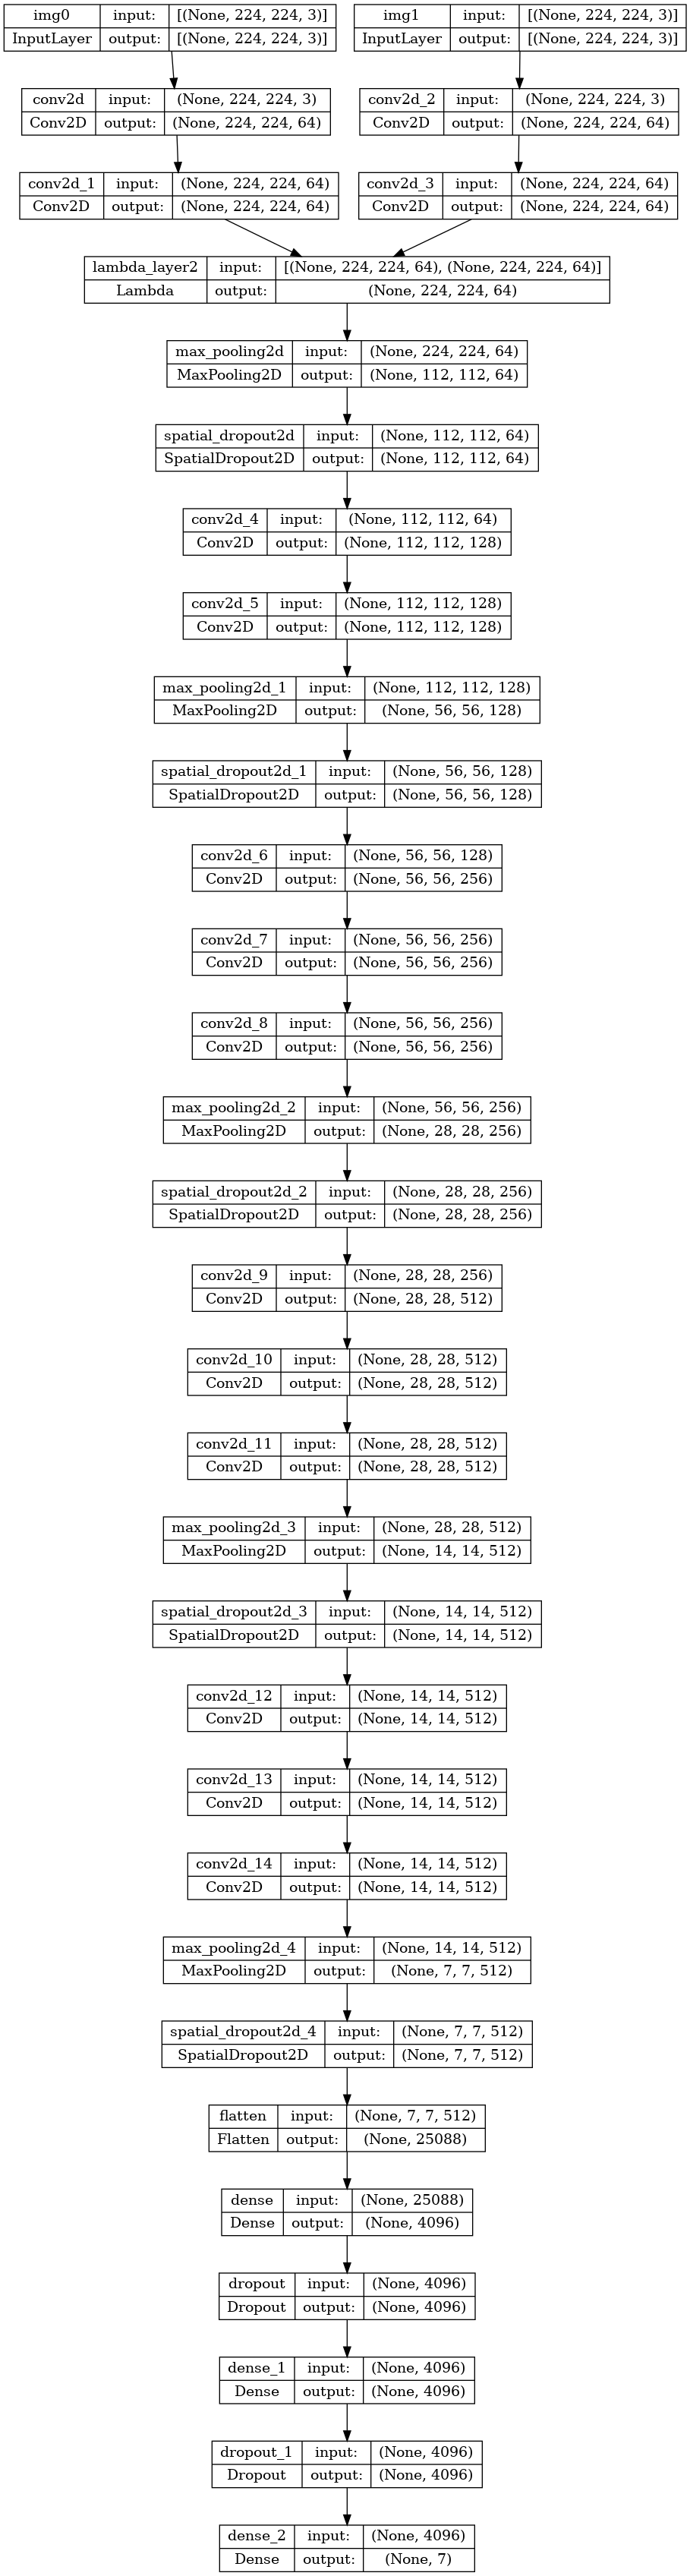

In [26]:
keras.utils.plot_model(model, "my_model_with_shape_info.png", show_shapes=True)

In [27]:
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)

In [28]:
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
maxAcc = np.max(fitHistory.history['val_accuracy'])

Start fitting from 2022/09/19-22:12:40

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40


2022-09-19 22:12:52.171322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1379 of 2553
2022-09-19 22:13:00.806794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-09-19 22:13:02.305547: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-09-19 22:13:05.143104: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2553/2553 [==============================] - 238s 83ms/step - loss: 2.0290 - accuracy: 0.1449 - val_loss: 1.9637 - val_accuracy: 0.1561 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
2553/2553 [==============================] - 202s 79ms/step - loss: 1.9674 - accuracy: 0.1481 - val_loss: 1.9566 - val_accuracy: 0.1561 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
2553/2553 [==============================] - 195s 76ms/step - loss: 1.9669 - accuracy: 0.1497 - val_loss: 1.9663 - val_accuracy: 0.1574 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
2553/2553 [==============================] - 194s 76ms/step - loss: 1.9658 - accuracy: 0.1528 - val_loss: 1.9582 - val_accuracy: 0.1574 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/40
2553/2553 [=========

Maximum test accuracy is at 94.86 %.


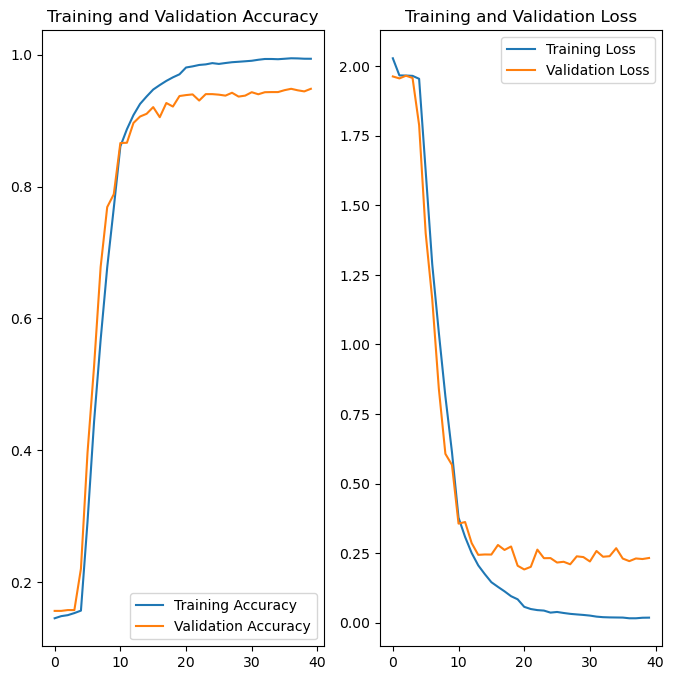

In [29]:
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)

In [30]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)

603/603 [==============================] - 12s 19ms/step
Confusion Matrix
[[726  18   3   0   0  11   1]
 [  7 719   0   0   0   0   0]
 [  0   0 618   0   1   8   0]
 [  1   0   0 571   0   0   0]
 [  2   0   2   0 619  15 121]
 [  0   0   5   7   6 609   0]
 [  0   0   0   0  40   0 713]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.99      0.96      0.97       759
      Aedes albopictus       0.98      0.99      0.98       726
          Aedes vexans       0.98      0.99      0.98       627
        An tessellatus       0.99      1.00      0.99       572
Culex quinquefasciatus       0.93      0.82      0.87       759
         Culex vishnui       0.95      0.97      0.96       627
                Others       0.85      0.95      0.90       753

              accuracy                           0.95      4823
             macro avg       0.95      0.95      0.95      4823
          weighted avg       0.95      0.9

In [31]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)

Start fitting from 2022/09/20-00:17:26

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
2553/2553 [==============================] - 221s 86ms/step - loss: 1.9721 - accuracy: 0.1555 - val_loss: 1.9422 - val_accuracy: 0.1574 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
2553/2553 [==============================] - 213s 83ms/step - loss: 1.6497 - accuracy: 0.2840 - val_loss: 1.4376 - val_accuracy: 0.3759 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
2553/2553 [==============================] - 214s 84ms/step - loss: 0.9811 - accuracy: 0.5756 - val_loss: 0.7798 - val_accuracy: 0.6486 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
2553/2553 [==============================] - 217s 85ms/step - loss: 0.6702 - accuracy: 0.7318 - val_loss: 0.4859 - val_accuracy: 0.803

Epoch 34/40
2553/2553 [==============================] - 219s 86ms/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.2632 - val_accuracy: 0.9587 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
2553/2553 [==============================] - 216s 85ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.2679 - val_accuracy: 0.9575 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
2553/2553 [==============================] - 217s 85ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.2794 - val_accuracy: 0.9569 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
2553/2553 [==============================] - 214s 84ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.2723 - val_accuracy: 0.9577 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
2553

Maximum test accuracy is at 96.0 %.


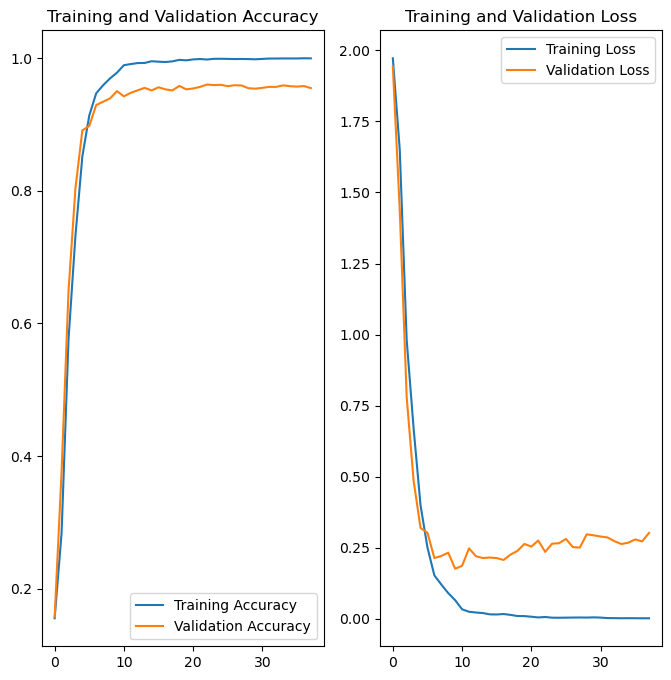

In [32]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)

In [33]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)

603/603 [==============================] - 14s 22ms/step
Confusion Matrix
[[751   5   0   0   0   3   0]
 [  9 717   0   0   0   0   0]
 [  0   0 621   2   0   4   0]
 [  0   0   0 572   0   0   0]
 [  1   0   3   4 633  23  95]
 [  0   0  10   0   3 614   0]
 [  0   0   0   0  31   0 722]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.99      0.99      0.99       759
      Aedes albopictus       0.99      0.99      0.99       726
          Aedes vexans       0.98      0.99      0.98       627
        An tessellatus       0.99      1.00      0.99       572
Culex quinquefasciatus       0.95      0.83      0.89       759
         Culex vishnui       0.95      0.98      0.97       627
                Others       0.88      0.96      0.92       753

              accuracy                           0.96      4823
             macro avg       0.96      0.96      0.96      4823
          weighted avg       0.96      0.9

In [34]:
model = buildLateModel()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)

Start fitting from 2022/09/20-02:33:38

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
2553/2553 [==============================] - 251s 98ms/step - loss: 1.9896 - accuracy: 0.1454 - val_loss: 1.9436 - val_accuracy: 0.1663 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
2553/2553 [==============================] - 247s 97ms/step - loss: 1.7713 - accuracy: 0.2328 - val_loss: 1.3859 - val_accuracy: 0.3869 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
2553/2553 [==============================] - 252s 99ms/step - loss: 1.1023 - accuracy: 0.5207 - val_loss: 0.9206 - val_accuracy: 0.6007 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
2553/2553 [==============================] - 244s 95ms/step - loss: 0.7539 - accuracy: 0.6941 - val_loss: 0.5287 - val_accuracy: 0.813

Maximum test accuracy is at 93.82 %.


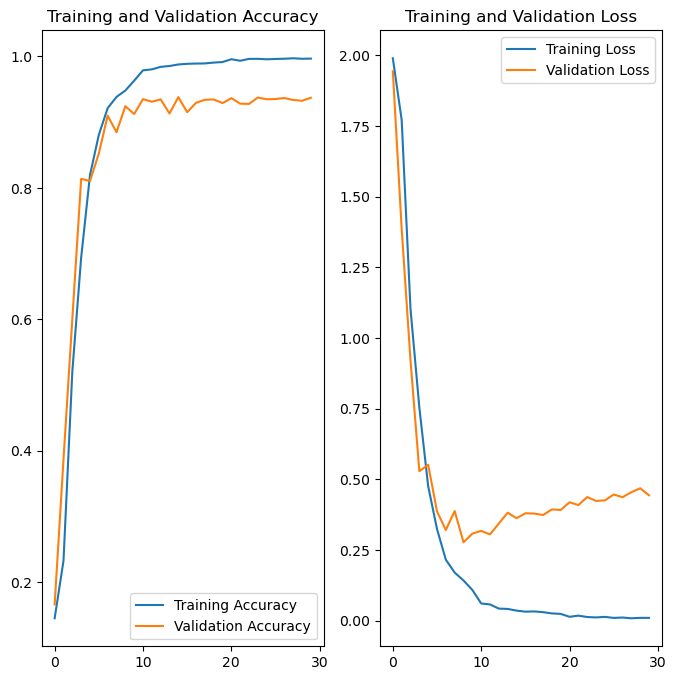

In [35]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)

In [36]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)

603/603 [==============================] - 16s 25ms/step
Confusion Matrix
[[746   3   2   1   1   5   1]
 [ 18 705   0   0   0   0   3]
 [  2   0 606   0   2  16   1]
 [  0   0   0 572   0   0   0]
 [  1   0   7   1 600  26 124]
 [  1   4  12   3   9 597   1]
 [  0   3   0   0  51   0 699]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.97      0.98      0.98       759
      Aedes albopictus       0.99      0.97      0.98       726
          Aedes vexans       0.97      0.97      0.97       627
        An tessellatus       0.99      1.00      1.00       572
Culex quinquefasciatus       0.90      0.79      0.84       759
         Culex vishnui       0.93      0.95      0.94       627
                Others       0.84      0.93      0.88       753

              accuracy                           0.94      4823
             macro avg       0.94      0.94      0.94      4823
          weighted avg       0.94      0.9

In [36]:
split_LMR = '/tmp/tmpl_z5wkb2'

In [40]:
earlyModelPath = './models/Model_Early_Combine_Park_2022-09-20_00-17.h5'
middleModelPath = './models/Model_Middle_Combine_Park_2022-09-20_02-33.h5'
lateModelPath = './models/Model_Late_Combine_Park_2022-09-20_04-37.h5'

In [37]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)

Found 13612 files belonging to 7 classes.
Found 3215 files belonging to 7 classes.
Found 13612 files belonging to 7 classes.
Found 3215 files belonging to 7 classes.
Found 13612 files belonging to 7 classes.
Found 3215 files belonging to 7 classes.


In [38]:
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)

In [41]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

2022-09-20 12:35:41.307526: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


   8/1702 [..............................] - ETA: 45s  

2022-09-20 12:35:44.492375: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


402/402 [==============================] - 9s 23ms/step


In [42]:
model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)


402/402 [==============================] - 10s 25ms/step


In [43]:
model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

402/402 [==============================] - 12s 29ms/step


In [44]:
Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))

In [45]:
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)

In [46]:
ensemble = trainEnsemble(Yh_train, Y_train)

Epoch 1/20
851/851 [==============================] - 4s 4ms/step - loss: 0.3297 - accuracy: 0.9318
Epoch 2/20
851/851 [==============================] - 4s 5ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 3/20
851/851 [==============================] - 4s 5ms/step - loss: 9.1869e-04 - accuracy: 1.0000
Epoch 4/20
851/851 [==============================] - 4s 5ms/step - loss: 4.3864e-04 - accuracy: 1.0000
Epoch 5/20
851/851 [==============================] - 4s 4ms/step - loss: 2.3863e-04 - accuracy: 1.0000
Epoch 6/20
851/851 [==============================] - 4s 5ms/step - loss: 1.4039e-04 - accuracy: 1.0000
Epoch 7/20
851/851 [==============================] - 4s 5ms/step - loss: 8.3817e-05 - accuracy: 1.0000
Epoch 8/20
851/851 [==============================] - 4s 5ms/step - loss: 5.2374e-05 - accuracy: 1.0000
Epoch 9/20
851/851 [==============================] - 4s 5ms/step - loss: 3.2868e-05 - accuracy: 1.0000
Epoch 10/20
851/851 [==============================] - 4s 5ms/step - los

In [47]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1

101/101 [==============================] - 1s 3ms/step - loss: 0.0386 - accuracy: 0.9925


101/101 [==============================] - 0s 2ms/step


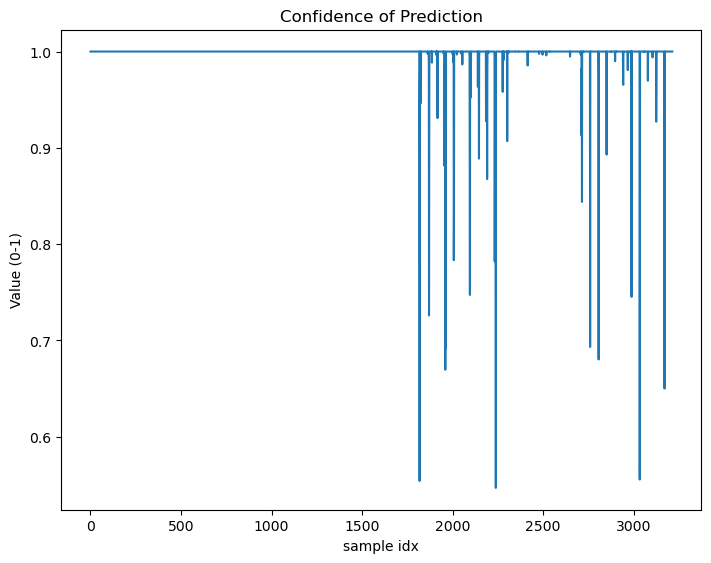

In [48]:
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)

In [57]:
import sys
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
gc.collect()
dir()
tf.keras.backend.clear_session()


In [58]:
#---------------MODEL2-----------------------------------------#

In [59]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Culex vishnui
No. of files in Culex vishnui = 6710.
No. of files in "/tmp/tmprpnn604t/train/Culex vishnui/" should be around 5368.
No. of files in /tmp/tmprpnn604t/train/Culex vishnui/ = 5423.
No. of files in "/tmp/tmprpnn604t/test/Culex vishnui/" should be around 0.
No. of files in /tmp/tmprpnn604t/test/Culex vishnui/ = 0.
No. of files in "/tmp/tmprpnn604t/val/Culex vishnui/" should be around 1342.
No. of files in /tmp/tmprpnn604t/val/Culex vishnui/ = 1287.
Found Culex quinquefasciatus
No. of files in Culex quinquefasciatus = 7909.
No. of files in "/tmp/tmprpnn604t/train/Culex quinquefasciatus/" should be around 6328.
No. of files in /tmp/tmprpnn604t/train/Culex quinquefasciatus/ = 6391.
No. of files in "/tmp/tmprpnn604t/test/Culex quinquefasciatus/" should be around 0.
No. of files in /tmp/tmprpnn604t/test/Culex quinquefasciatus/ = 0.
No. of files in "/tmp/tmprpnn604t/val/Culex quinquefasciatus/" should be around 1582.
No. of files in /tmp/tmprpnn604t/

((20391, 4849, 0), (13592, 3232, 0))

In [60]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 20391 files belonging to 7 classes.
Found 4849 files belonging to 7 classes.
Found 20391 files belonging to 7 classes.
Found 4849 files belonging to 7 classes.


In [61]:
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/09/20-15:06:59

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40


2022-09-20 15:07:10.484834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1402 of 2549
2022-09-20 15:07:17.869952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


2549/2549 [==============================] - 227s 81ms/step - loss: 1.9995 - accuracy: 0.1483 - val_loss: 1.9403 - val_accuracy: 0.1598 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
2549/2549 [==============================] - 204s 80ms/step - loss: 1.9352 - accuracy: 0.1750 - val_loss: 1.8683 - val_accuracy: 0.2227 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
2549/2549 [==============================] - 200s 78ms/step - loss: 1.6112 - accuracy: 0.2957 - val_loss: 1.2607 - val_accuracy: 0.3770 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
2549/2549 [==============================] - 202s 79ms/step - loss: 1.0857 - accuracy: 0.5273 - val_loss: 0.9183 - val_accuracy: 0.5797 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/40
2549/2549 [=========

Maximum test accuracy is at 95.17 %.


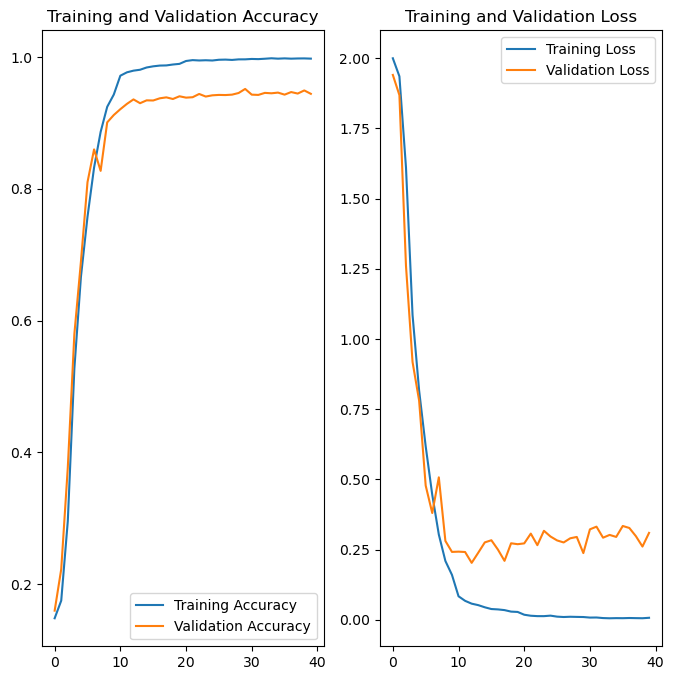

In [62]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [64]:
class_names = ['Aedes aegypti', 'Aedes albopictus', 'Aedes vexans', 'An tessellatus', 'Culex quinquefasciatus', 'Culex vishnui', 'Others']
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

607/607 [==============================] - 13s 21ms/step
Confusion Matrix
[[770   4   1   0   0   0   0]
 [ 17 703   0   0   0   0   0]
 [  0   0 605   0   0   0   0]
 [  0   0   1 582   0   0   0]
 [  2   0   5   0 563  22 167]
 [  0   0  16   0  14 613   0]
 [  1   3   1   0  14   2 743]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.97      0.99      0.98       775
      Aedes albopictus       0.99      0.98      0.98       720
          Aedes vexans       0.96      1.00      0.98       605
        An tessellatus       1.00      1.00      1.00       583
Culex quinquefasciatus       0.95      0.74      0.83       759
         Culex vishnui       0.96      0.95      0.96       643
                Others       0.82      0.97      0.89       764

              accuracy                           0.94      4849
             macro avg       0.95      0.95      0.95      4849
          weighted avg       0.95      0.9

In [65]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

                                                                                                  
 spatial_dropout2d_10 (SpatialD  (None, 14, 14, 512)  0          ['max_pooling2d_10[0][0]']       
 ropout2D)                                                                                        
                                                                                                  
 conv2d_32 (Conv2D)             (None, 14, 14, 512)  2359808     ['spatial_dropout2d_10[0][0]']   
                                                                                                  
 conv2d_33 (Conv2D)             (None, 14, 14, 512)  2359808     ['conv2d_32[0][0]']              
                                                                                                  
 conv2d_34 (Conv2D)             (None, 14, 14, 512)  2359808     ['conv2d_33[0][0]']              
                                                                                                  
 max_pooli


Epoch 22: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 22/40
2549/2549 [==============================] - 242s 95ms/step - loss: 0.0501 - accuracy: 0.9828 - val_loss: 0.1485 - val_accuracy: 0.9503 - lr: 5.0000e-06

Epoch 23: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 23/40
2549/2549 [==============================] - 220s 86ms/step - loss: 0.0416 - accuracy: 0.9856 - val_loss: 0.2123 - val_accuracy: 0.9392 - lr: 5.0000e-06

Epoch 24: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 24/40
2549/2549 [==============================] - 220s 86ms/step - loss: 0.0374 - accuracy: 0.9872 - val_loss: 0.1472 - val_accuracy: 0.9569 - lr: 5.0000e-06

Epoch 25: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 25/40
2549/2549 [==============================] - 215s 84ms/step - loss: 0.0339 - accuracy: 0.9876 - val_loss: 0.2134 - val_accuracy: 0.9482 - lr: 5.0000e-06

Epoch 26: Learn

Maximum test accuracy is at 95.79 %.


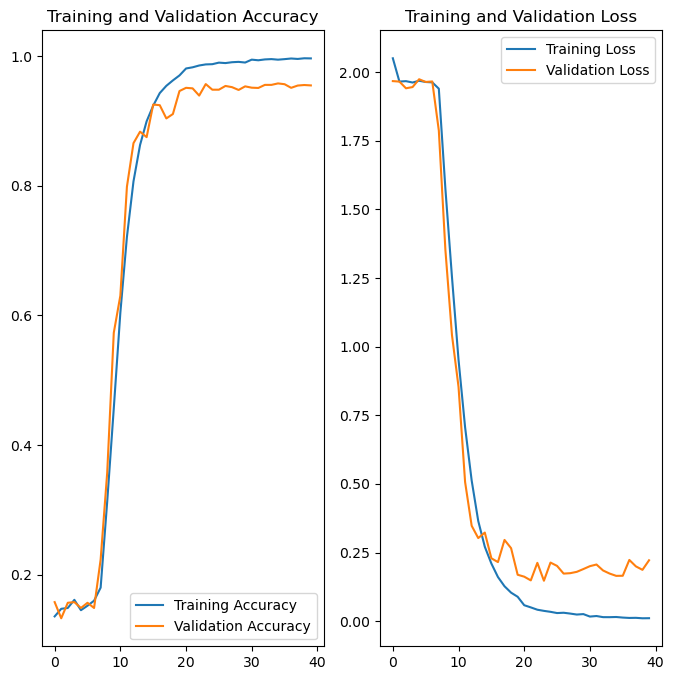

In [66]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [67]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

607/607 [==============================] - 14s 23ms/step
Confusion Matrix
[[773   1   0   0   1   0   0]
 [ 22 698   0   0   0   0   0]
 [  1   0 604   0   0   0   0]
 [  0   0   3 580   0   0   0]
 [  0   0   0   0 585   8 166]
 [  0   0   3   0   8 632   0]
 [  0   0   0   2   4   0 758]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.97      1.00      0.98       775
      Aedes albopictus       1.00      0.97      0.98       720
          Aedes vexans       0.99      1.00      0.99       605
        An tessellatus       1.00      0.99      1.00       583
Culex quinquefasciatus       0.98      0.77      0.86       759
         Culex vishnui       0.99      0.98      0.99       643
                Others       0.82      0.99      0.90       764

              accuracy                           0.95      4849
             macro avg       0.96      0.96      0.96      4849
          weighted avg       0.96      0.9

In [68]:
model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_35 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

 conv2d_55 (Conv2D)             (None, 28, 28, 512)  1180160     ['spatial_dropout2d_18[0][0]']   
                                                                                                  
 conv2d_43 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_42[0][0]']              
                                                                                                  
 conv2d_56 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_55[0][0]']              
                                                                                                  
 conv2d_44 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_43[0][0]']              
                                                                                                  
 conv2d_57 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_56[0][0]']              
                                                                                                  
 max_pooli

Epoch 12/40
2549/2549 [==============================] - 243s 95ms/step - loss: 0.0132 - accuracy: 0.9956 - val_loss: 0.1887 - val_accuracy: 0.9588 - lr: 1.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 13/40
2549/2549 [==============================] - 243s 95ms/step - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0.1798 - val_accuracy: 0.9585 - lr: 1.0000e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 14/40
2549/2549 [==============================] - 237s 93ms/step - loss: 0.0104 - accuracy: 0.9967 - val_loss: 0.1993 - val_accuracy: 0.9600 - lr: 1.0000e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 15/40
2549/2549 [==============================] - 244s 96ms/step - loss: 0.0099 - accuracy: 0.9968 - val_loss: 0.1897 - val_accuracy: 0.9627 - lr: 1.0000e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 16/40
2549

Maximum test accuracy is at 96.68 %.


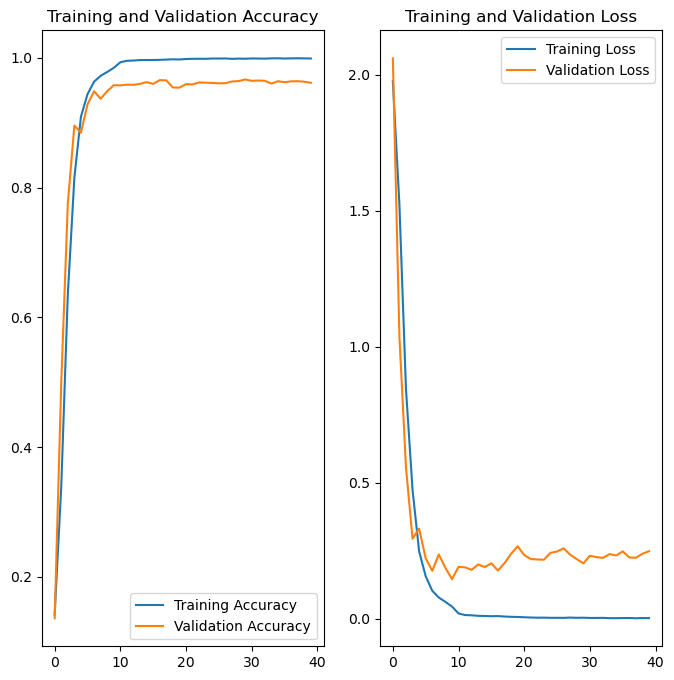

In [69]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [70]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

607/607 [==============================] - 16s 26ms/step
Confusion Matrix
[[773   2   0   0   0   0   0]
 [  9 711   0   0   0   0   0]
 [  0   0 604   0   0   1   0]
 [  0   0   0 583   0   0   0]
 [  0   0  10   1 609  10 129]
 [  0   0  21   0   0 622   0]
 [  0   1   0   1   1   0 761]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.99      1.00      0.99       775
      Aedes albopictus       1.00      0.99      0.99       720
          Aedes vexans       0.95      1.00      0.97       605
        An tessellatus       1.00      1.00      1.00       583
Culex quinquefasciatus       1.00      0.80      0.89       759
         Culex vishnui       0.98      0.97      0.97       643
                Others       0.86      1.00      0.92       764

              accuracy                           0.96      4849
             macro avg       0.97      0.96      0.96      4849
          weighted avg       0.97      0.9

In [71]:
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
gc.collect()
dir()
tf.keras.backend.clear_session()

In [72]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 13592 files belonging to 7 classes.
Found 3232 files belonging to 7 classes.
Found 13592 files belonging to 7 classes.
Found 3232 files belonging to 7 classes.
Found 13592 files belonging to 7 classes.
Found 3232 files belonging to 7 classes.


In [73]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

404/404 [==============================] - 11s 28ms/step


In [74]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------


Epoch 1/20
850/850 [==============================] - 4s 4ms/step - loss: 0.4096 - accuracy: 0.8724
Epoch 2/20
850/850 [==============================] - 4s 4ms/step - loss: 0.0052 - accuracy: 0.9999
Epoch 3/20
850/850 [==============================] - 4s 5ms/step - loss: 0.0017 - accuracy: 0.9999
Epoch 4/20
850/850 [==============================] - 4s 5ms/step - loss: 7.7358e-04 - accuracy: 0.9999
Epoch 5/20
850/850 [==============================] - 4s 5ms/step - loss: 4.2106e-04 - accuracy: 1.0000
Epoch 6/20
850/850 [==============================] - 4s 5ms/step - loss: 2.6721e-04 - accuracy: 1.0000
Epoch 7/20
850/850 [==============================] - 4s 5ms/step - loss: 1.6599e-04 - accuracy: 1.0000
Epoch 8/20
850/850 [==============================] - 4s 5ms/step - loss: 1.0728e-04 - accuracy: 1.0000
Epoch 9/20
850/850 [==============================] - 4s 5ms/step - loss: 8.1737e-05 - accuracy: 1.0000
Epoch 10/20
850/850 [==============================] - 4s 4ms/step - loss: 5

101/101 [==============================] - 0s 1ms/step


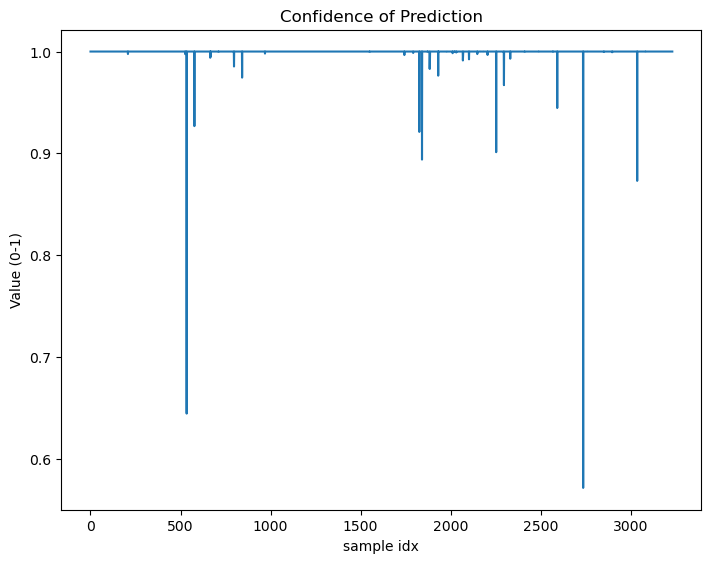

In [75]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)
#----------------------------------


In [76]:
import sys
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
tf.keras.backend.clear_session()
gc.collect()

25027

In [77]:
#---------------MODEL3-----------------------------------------#

In [78]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----



Ratio = (0.8, 0.2, -0.0).
Found Culex vishnui
No. of files in Culex vishnui = 6710.
No. of files in "/tmp/tmpibq4brj3/train/Culex vishnui/" should be around 5368.
No. of files in /tmp/tmpibq4brj3/train/Culex vishnui/ = 5423.
No. of files in "/tmp/tmpibq4brj3/test/Culex vishnui/" should be around 0.
No. of files in /tmp/tmpibq4brj3/test/Culex vishnui/ = 0.
No. of files in "/tmp/tmpibq4brj3/val/Culex vishnui/" should be around 1342.
No. of files in /tmp/tmpibq4brj3/val/Culex vishnui/ = 1287.
Found Culex quinquefasciatus
No. of files in Culex quinquefasciatus = 7909.
No. of files in "/tmp/tmpibq4brj3/train/Culex quinquefasciatus/" should be around 6328.
No. of files in /tmp/tmpibq4brj3/train/Culex quinquefasciatus/ = 6369.
No. of files in "/tmp/tmpibq4brj3/test/Culex quinquefasciatus/" should be around 0.
No. of files in /tmp/tmpibq4brj3/test/Culex quinquefasciatus/ = 0.
No. of files in "/tmp/tmpibq4brj3/val/Culex quinquefasciatus/" should be around 1582.
No. of files in /tmp/tmpibq4brj3/

((20336, 4905, 0), (13557, 3269, 0))

In [79]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 20336 files belonging to 7 classes.
Found 4905 files belonging to 7 classes.
Found 20336 files belonging to 7 classes.
Found 4905 files belonging to 7 classes.


In [80]:
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/09/21-03:48:46

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40


2022-09-21 03:48:58.136712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1529 of 2542


   3/2542 [..............................] - ETA: 2:38 - loss: 3.4501 - accuracy: 0.0000e+00  

2022-09-21 03:49:04.819457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


2542/2542 [==============================] - 209s 75ms/step - loss: 2.0433 - accuracy: 0.1458 - val_loss: 2.0070 - val_accuracy: 0.1547 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
2542/2542 [==============================] - 190s 75ms/step - loss: 1.9619 - accuracy: 0.1575 - val_loss: 1.9716 - val_accuracy: 0.1547 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
2542/2542 [==============================] - 184s 72ms/step - loss: 1.9679 - accuracy: 0.1474 - val_loss: 1.9696 - val_accuracy: 0.1311 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
2542/2542 [==============================] - 174s 68ms/step - loss: 1.9645 - accuracy: 0.1416 - val_loss: 1.9758 - val_accuracy: 0.1547 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/40
2542/2542 [=========

Maximum test accuracy is at 96.53 %.


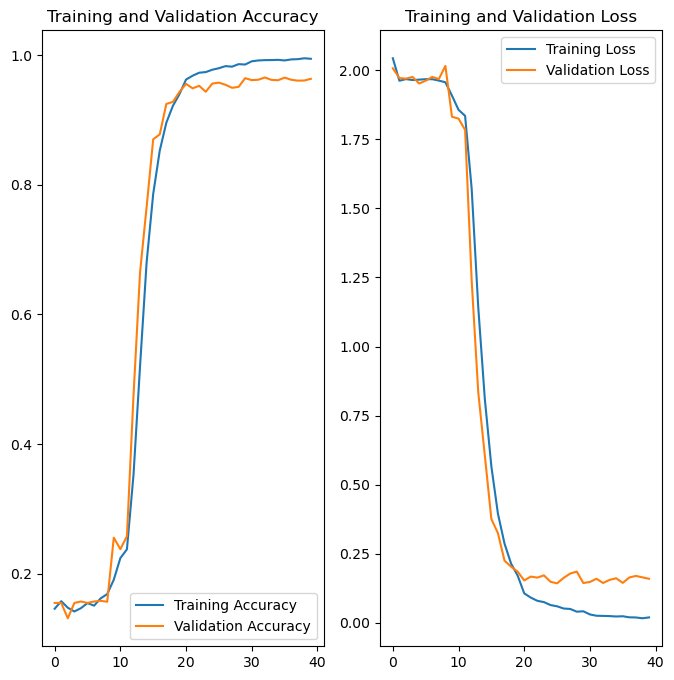

In [81]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [82]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

614/614 [==============================] - 12s 19ms/step
Confusion Matrix
[[750   4   0   0   0   4   1]
 [ 18 706   0   0   0   0   2]
 [  0   0 638   1   1   9   0]
 [  0   0   2 576   3   1   1]
 [  0   0   0   0 667  34  69]
 [  0   0   5   3   0 635   0]
 [  0   0   0   0  16   6 753]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.98      0.99      0.98       759
      Aedes albopictus       0.99      0.97      0.98       726
          Aedes vexans       0.99      0.98      0.99       649
        An tessellatus       0.99      0.99      0.99       583
Culex quinquefasciatus       0.97      0.87      0.92       770
         Culex vishnui       0.92      0.99      0.95       643
                Others       0.91      0.97      0.94       775

              accuracy                           0.96      4905
             macro avg       0.97      0.97      0.96      4905
          weighted avg       0.96      0.9

In [83]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

                                                                                                  
 spatial_dropout2d_10 (SpatialD  (None, 14, 14, 512)  0          ['max_pooling2d_10[0][0]']       
 ropout2D)                                                                                        
                                                                                                  
 conv2d_32 (Conv2D)             (None, 14, 14, 512)  2359808     ['spatial_dropout2d_10[0][0]']   
                                                                                                  
 conv2d_33 (Conv2D)             (None, 14, 14, 512)  2359808     ['conv2d_32[0][0]']              
                                                                                                  
 conv2d_34 (Conv2D)             (None, 14, 14, 512)  2359808     ['conv2d_33[0][0]']              
                                                                                                  
 max_pooli


Epoch 22: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 22/40
2542/2542 [==============================] - 206s 81ms/step - loss: 0.0077 - accuracy: 0.9972 - val_loss: 0.1150 - val_accuracy: 0.9778 - lr: 5.0000e-06

Epoch 23: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 23/40
2542/2542 [==============================] - 210s 83ms/step - loss: 0.0092 - accuracy: 0.9969 - val_loss: 0.1174 - val_accuracy: 0.9768 - lr: 5.0000e-06

Epoch 24: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 24/40
2542/2542 [==============================] - 210s 83ms/step - loss: 0.0077 - accuracy: 0.9977 - val_loss: 0.1050 - val_accuracy: 0.9817 - lr: 5.0000e-06

Epoch 25: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 25/40
2542/2542 [==============================] - 207s 81ms/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.1246 - val_accuracy: 0.9788 - lr: 5.0000e-06

Epoch 26: Learn

Maximum test accuracy is at 98.19 %.


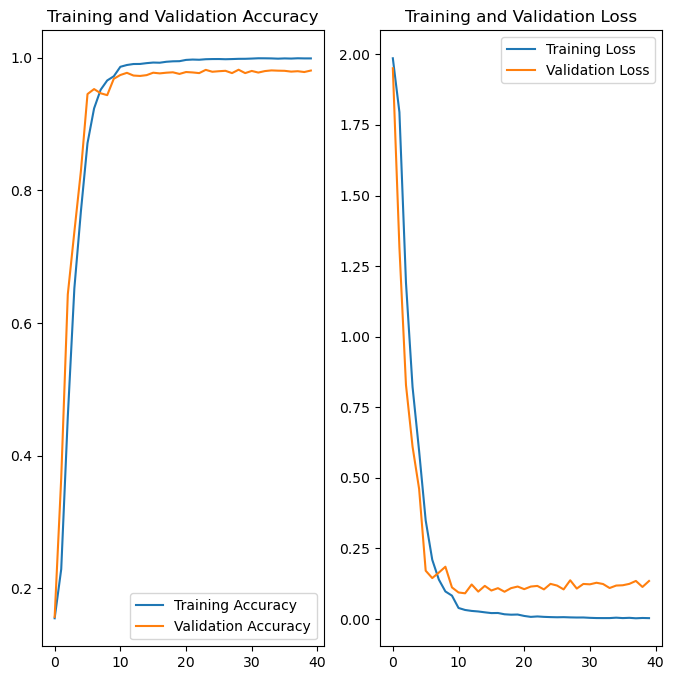

In [84]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [85]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

614/614 [==============================] - 14s 22ms/step
Confusion Matrix
[[757   2   0   0   0   0   0]
 [ 13 713   0   0   0   0   0]
 [  0   0 647   0   0   2   0]
 [  0   0   0 583   0   0   0]
 [  0   0   0   0 697   6  67]
 [  1   0   0   0   1 641   0]
 [  0   0   0   0   3   0 772]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.98      1.00      0.99       759
      Aedes albopictus       1.00      0.98      0.99       726
          Aedes vexans       1.00      1.00      1.00       649
        An tessellatus       1.00      1.00      1.00       583
Culex quinquefasciatus       0.99      0.91      0.95       770
         Culex vishnui       0.99      1.00      0.99       643
                Others       0.92      1.00      0.96       775

              accuracy                           0.98      4905
             macro avg       0.98      0.98      0.98      4905
          weighted avg       0.98      0.9

In [86]:
model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_35 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

 conv2d_55 (Conv2D)             (None, 28, 28, 512)  1180160     ['spatial_dropout2d_18[0][0]']   
                                                                                                  
 conv2d_43 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_42[0][0]']              
                                                                                                  
 conv2d_56 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_55[0][0]']              
                                                                                                  
 conv2d_44 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_43[0][0]']              
                                                                                                  
 conv2d_57 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_56[0][0]']              
                                                                                                  
 max_pooli

Epoch 12/40
2542/2542 [==============================] - 240s 94ms/step - loss: 0.0117 - accuracy: 0.9956 - val_loss: 0.1231 - val_accuracy: 0.9766 - lr: 1.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 13/40
2542/2542 [==============================] - 241s 95ms/step - loss: 0.0101 - accuracy: 0.9965 - val_loss: 0.1205 - val_accuracy: 0.9768 - lr: 1.0000e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 14/40
2542/2542 [==============================] - 239s 94ms/step - loss: 0.0103 - accuracy: 0.9965 - val_loss: 0.0981 - val_accuracy: 0.9761 - lr: 1.0000e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 15/40
2542/2542 [==============================] - 243s 95ms/step - loss: 0.0093 - accuracy: 0.9974 - val_loss: 0.1367 - val_accuracy: 0.9749 - lr: 1.0000e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 16/40
2542

Maximum test accuracy is at 98.19 %.


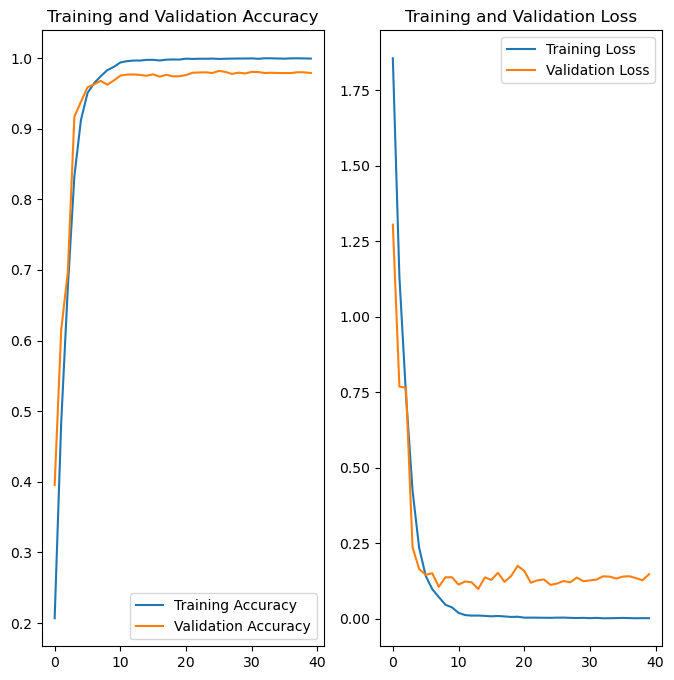

In [87]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [88]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

614/614 [==============================] - 16s 26ms/step
Confusion Matrix
[[757   2   0   0   0   0   0]
 [  4 722   0   0   0   0   0]
 [  1   0 641   0   0   7   0]
 [  0   0   0 583   0   0   0]
 [  0   0   1   0 690   7  72]
 [  0   0   2   0   0 641   0]
 [  0   0   0   0   8   0 767]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.99      1.00      1.00       759
      Aedes albopictus       1.00      0.99      1.00       726
          Aedes vexans       1.00      0.99      0.99       649
        An tessellatus       1.00      1.00      1.00       583
Culex quinquefasciatus       0.99      0.90      0.94       770
         Culex vishnui       0.98      1.00      0.99       643
                Others       0.91      0.99      0.95       775

              accuracy                           0.98      4905
             macro avg       0.98      0.98      0.98      4905
          weighted avg       0.98      0.9

In [89]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 13557 files belonging to 7 classes.
Found 3269 files belonging to 7 classes.
Found 13557 files belonging to 7 classes.
Found 3269 files belonging to 7 classes.
Found 13557 files belonging to 7 classes.
Found 3269 files belonging to 7 classes.


In [90]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

409/409 [==============================] - 12s 29ms/step


In [91]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------


Epoch 1/20
848/848 [==============================] - 4s 4ms/step - loss: 0.2253 - accuracy: 0.9414
Epoch 2/20
848/848 [==============================] - 4s 4ms/step - loss: 0.0036 - accuracy: 0.9999
Epoch 3/20
848/848 [==============================] - 3s 4ms/step - loss: 0.0013 - accuracy: 0.9999
Epoch 4/20
848/848 [==============================] - 4s 4ms/step - loss: 6.6805e-04 - accuracy: 1.0000
Epoch 5/20
848/848 [==============================] - 3s 4ms/step - loss: 4.0314e-04 - accuracy: 1.0000
Epoch 6/20
848/848 [==============================] - 4s 4ms/step - loss: 2.6219e-04 - accuracy: 1.0000
Epoch 7/20
848/848 [==============================] - 3s 4ms/step - loss: 1.7569e-04 - accuracy: 1.0000
Epoch 8/20
848/848 [==============================] - 4s 4ms/step - loss: 1.1506e-04 - accuracy: 1.0000
Epoch 9/20
848/848 [==============================] - 3s 3ms/step - loss: 9.2954e-05 - accuracy: 1.0000
Epoch 10/20
848/848 [==============================] - 4s 4ms/step - loss: 6

103/103 [==============================] - 0s 1ms/step


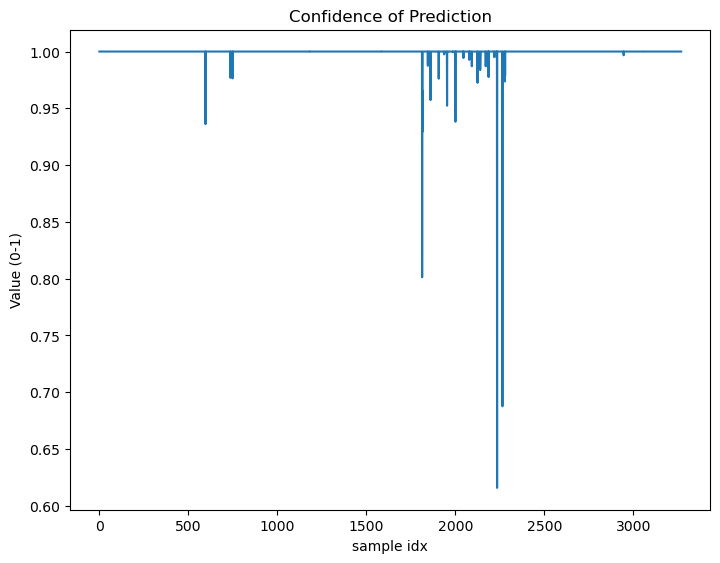

In [92]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)
#----------------------------------


In [93]:
import sys
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
tf.keras.backend.clear_session()
gc.collect()

28762

In [94]:
#---------------MODEL4-----------------------------------------#

In [95]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Culex vishnui
No. of files in Culex vishnui = 6710.
No. of files in "/tmp/tmpon2d97u1/train/Culex vishnui/" should be around 5368.
No. of files in /tmp/tmpon2d97u1/train/Culex vishnui/ = 5368.
No. of files in "/tmp/tmpon2d97u1/test/Culex vishnui/" should be around 0.
No. of files in /tmp/tmpon2d97u1/test/Culex vishnui/ = 0.
No. of files in "/tmp/tmpon2d97u1/val/Culex vishnui/" should be around 1342.
No. of files in /tmp/tmpon2d97u1/val/Culex vishnui/ = 1342.
Found Culex quinquefasciatus
No. of files in Culex quinquefasciatus = 7909.
No. of files in "/tmp/tmpon2d97u1/train/Culex quinquefasciatus/" should be around 6328.
No. of files in /tmp/tmpon2d97u1/train/Culex quinquefasciatus/ = 6380.
No. of files in "/tmp/tmpon2d97u1/test/Culex quinquefasciatus/" should be around 0.
No. of files in /tmp/tmpon2d97u1/test/Culex quinquefasciatus/ = 0.
No. of files in "/tmp/tmpon2d97u1/val/Culex quinquefasciatus/" should be around 1582.
No. of files in /tmp/tmpon2d97u1/

((20288, 4955, 0), (13523, 3300, 0))

In [96]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 20288 files belonging to 7 classes.
Found 4955 files belonging to 7 classes.
Found 20288 files belonging to 7 classes.
Found 4955 files belonging to 7 classes.


In [97]:
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/09/21-11:05:05

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40


2022-09-21 11:05:17.006246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1570 of 2536


   3/2536 [..............................] - ETA: 2:45 - loss: 2.5300 - accuracy: 0.2917      

2022-09-21 11:05:22.902813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


2536/2536 [==============================] - 203s 73ms/step - loss: 1.9746 - accuracy: 0.1571 - val_loss: 1.9467 - val_accuracy: 0.1665 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
2536/2536 [==============================] - 184s 73ms/step - loss: 1.6835 - accuracy: 0.2616 - val_loss: 1.3245 - val_accuracy: 0.3570 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
2536/2536 [==============================] - 172s 68ms/step - loss: 1.1446 - accuracy: 0.4784 - val_loss: 1.0361 - val_accuracy: 0.5062 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
2536/2536 [==============================] - 173s 68ms/step - loss: 0.8354 - accuracy: 0.6414 - val_loss: 0.8695 - val_accuracy: 0.6791 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/40
2536/2536 [=========

Maximum test accuracy is at 96.31 %.


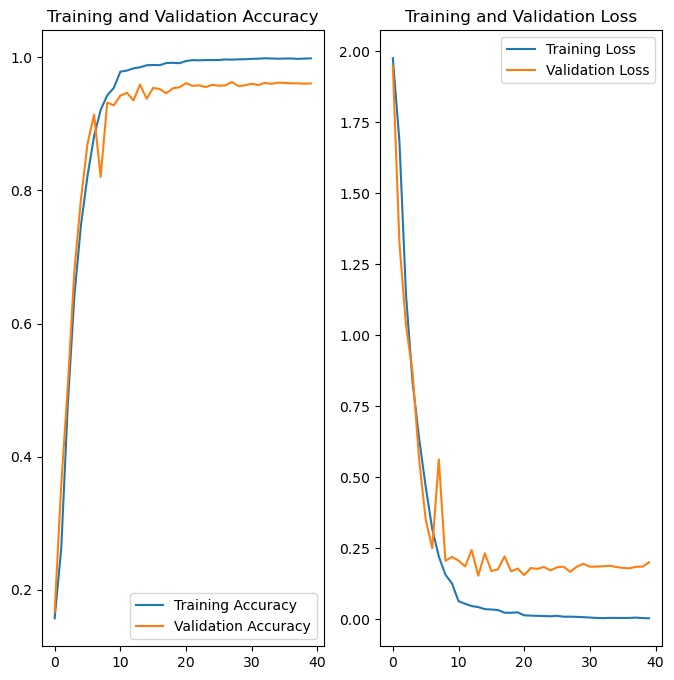

In [98]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [99]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

620/620 [==============================] - 13s 20ms/step
Confusion Matrix
[[812   7   1   0   1   4   0]
 [ 35 670   0   3   4   0   3]
 [  0   0 646   0   0   3   0]
 [  1   0   1 580   0   1   0]
 [  0   0   1   1 742   8  12]
 [  5   0  33   6  26 601   0]
 [  0   0   0   1  37   0 710]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.95      0.98      0.97       825
      Aedes albopictus       0.99      0.94      0.96       715
          Aedes vexans       0.95      1.00      0.97       649
        An tessellatus       0.98      0.99      0.99       583
Culex quinquefasciatus       0.92      0.97      0.94       764
         Culex vishnui       0.97      0.90      0.93       671
                Others       0.98      0.95      0.96       748

              accuracy                           0.96      4955
             macro avg       0.96      0.96      0.96      4955
          weighted avg       0.96      0.9

In [100]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

                                                                                                  
 spatial_dropout2d_10 (SpatialD  (None, 14, 14, 512)  0          ['max_pooling2d_10[0][0]']       
 ropout2D)                                                                                        
                                                                                                  
 conv2d_32 (Conv2D)             (None, 14, 14, 512)  2359808     ['spatial_dropout2d_10[0][0]']   
                                                                                                  
 conv2d_33 (Conv2D)             (None, 14, 14, 512)  2359808     ['conv2d_32[0][0]']              
                                                                                                  
 conv2d_34 (Conv2D)             (None, 14, 14, 512)  2359808     ['conv2d_33[0][0]']              
                                                                                                  
 max_pooli


Epoch 22: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 22/40
2536/2536 [==============================] - 208s 82ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.1300 - val_accuracy: 0.9705 - lr: 5.0000e-06

Epoch 23: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 23/40
2536/2536 [==============================] - 209s 82ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.1540 - val_accuracy: 0.9675 - lr: 5.0000e-06

Epoch 24: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 24/40
2536/2536 [==============================] - 207s 82ms/step - loss: 0.0058 - accuracy: 0.9983 - val_loss: 0.2245 - val_accuracy: 0.9487 - lr: 5.0000e-06

Epoch 25: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 25/40
2536/2536 [==============================] - 203s 80ms/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 0.1280 - val_accuracy: 0.9740 - lr: 5.0000e-06

Epoch 26: Learn

Maximum test accuracy is at 97.5 %.


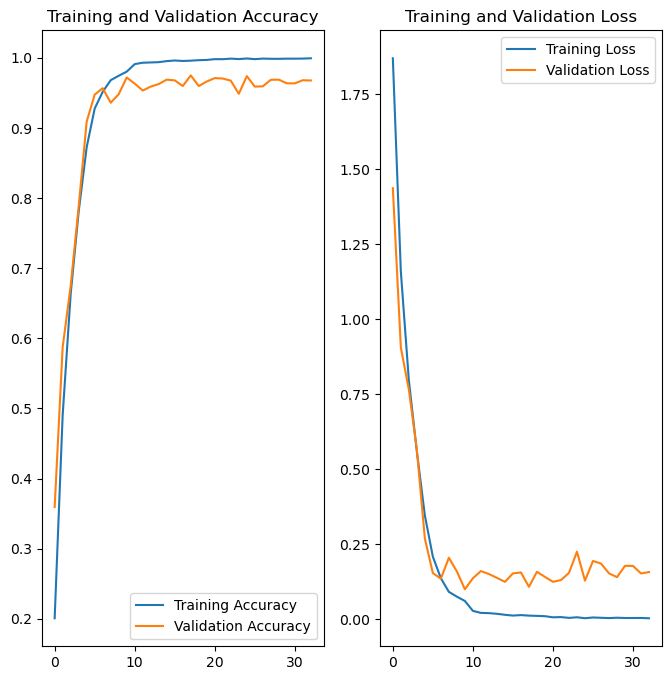

In [101]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [102]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

620/620 [==============================] - 14s 22ms/step
Confusion Matrix
[[820   1   0   1   0   3   0]
 [ 37 678   0   0   0   0   0]
 [  0   0 642   0   0   7   0]
 [  2   0   0 579   1   1   0]
 [  2   0   0   0 729  28   5]
 [  6   1   4   1  10 648   1]
 [  0   0   0   0  13   0 735]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.95      0.99      0.97       825
      Aedes albopictus       1.00      0.95      0.97       715
          Aedes vexans       0.99      0.99      0.99       649
        An tessellatus       1.00      0.99      0.99       583
Culex quinquefasciatus       0.97      0.95      0.96       764
         Culex vishnui       0.94      0.97      0.95       671
                Others       0.99      0.98      0.99       748

              accuracy                           0.97      4955
             macro avg       0.98      0.98      0.98      4955
          weighted avg       0.98      0.9

In [103]:
model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_35 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

 conv2d_55 (Conv2D)             (None, 28, 28, 512)  1180160     ['spatial_dropout2d_18[0][0]']   
                                                                                                  
 conv2d_43 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_42[0][0]']              
                                                                                                  
 conv2d_56 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_55[0][0]']              
                                                                                                  
 conv2d_44 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_43[0][0]']              
                                                                                                  
 conv2d_57 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_56[0][0]']              
                                                                                                  
 max_pooli

Epoch 12/40
2536/2536 [==============================] - 239s 94ms/step - loss: 0.0150 - accuracy: 0.9950 - val_loss: 0.3029 - val_accuracy: 0.9267 - lr: 1.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 13/40
2536/2536 [==============================] - 234s 92ms/step - loss: 0.0143 - accuracy: 0.9950 - val_loss: 0.2619 - val_accuracy: 0.9300 - lr: 1.0000e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 14/40
2536/2536 [==============================] - 237s 93ms/step - loss: 0.0118 - accuracy: 0.9965 - val_loss: 0.3022 - val_accuracy: 0.9267 - lr: 1.0000e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 15/40
2536/2536 [==============================] - 236s 93ms/step - loss: 0.0114 - accuracy: 0.9963 - val_loss: 0.2796 - val_accuracy: 0.9298 - lr: 1.0000e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 16/40
2536

Maximum test accuracy is at 93.97 %.


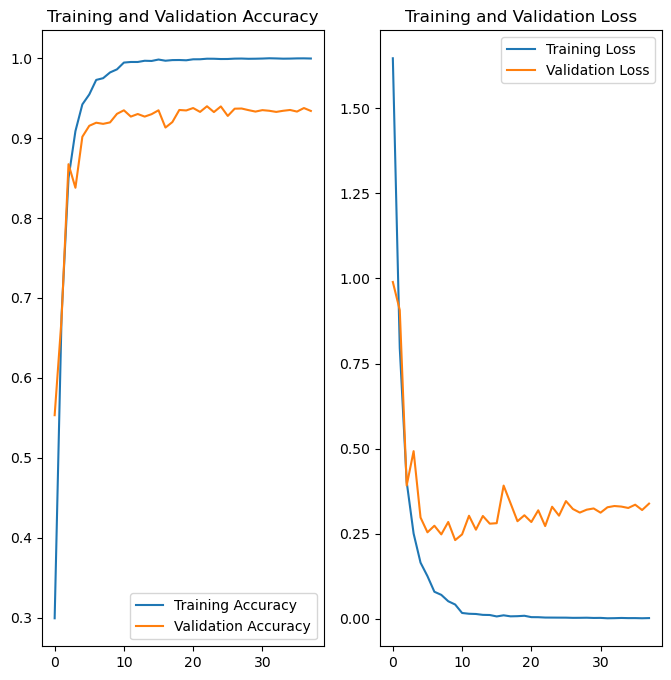

In [104]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [105]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

620/620 [==============================] - 18s 28ms/step
Confusion Matrix
[[792  24   8   1   0   0   0]
 [ 34 680   1   0   0   0   0]
 [  0   0 649   0   0   0   0]
 [  0   0   1 574   2   3   3]
 [ 16   0   1   0 679  19  49]
 [  3   1  35   0  16 614   2]
 [  0   0   5   0  73   2 668]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.94      0.96      0.95       825
      Aedes albopictus       0.96      0.95      0.96       715
          Aedes vexans       0.93      1.00      0.96       649
        An tessellatus       1.00      0.98      0.99       583
Culex quinquefasciatus       0.88      0.89      0.89       764
         Culex vishnui       0.96      0.92      0.94       671
                Others       0.93      0.89      0.91       748

              accuracy                           0.94      4955
             macro avg       0.94      0.94      0.94      4955
          weighted avg       0.94      0.9

In [106]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 13523 files belonging to 7 classes.
Found 3300 files belonging to 7 classes.
Found 13523 files belonging to 7 classes.
Found 3300 files belonging to 7 classes.
Found 13523 files belonging to 7 classes.
Found 3300 files belonging to 7 classes.


In [107]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

413/413 [==============================] - 12s 30ms/step


In [108]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
846/846 [==============================] - 4s 5ms/step - loss: 0.3293 - accuracy: 0.9266
Epoch 2/20
846/846 [==============================] - 4s 5ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 3/20
846/846 [==============================] - 4s 5ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 4/20
846/846 [==============================] - 3s 4ms/step - loss: 6.1544e-04 - accuracy: 1.0000
Epoch 5/20
846/846 [==============================] - 3s 4ms/step - loss: 3.0699e-04 - accuracy: 1.0000
Epoch 6/20
846/846 [==============================] - 3s 4ms/step - loss: 1.6916e-04 - accuracy: 1.0000
Epoch 7/20
846/846 [==============================] - 4s 4ms/step - loss: 9.7960e-05 - accuracy: 1.0000
Epoch 8/20
846/846 [==============================] - 4s 4ms/step - loss: 5.8945e-05 - accuracy: 1.0000
Epoch 9/20
846/846 [==============================] - 4s 4ms/step - loss: 3.6273e-05 - accuracy: 1.0000
Epoch 10/20
846/846 [==============================] - 4s 4ms/step - loss: 2

104/104 [==============================] - 0s 1ms/step


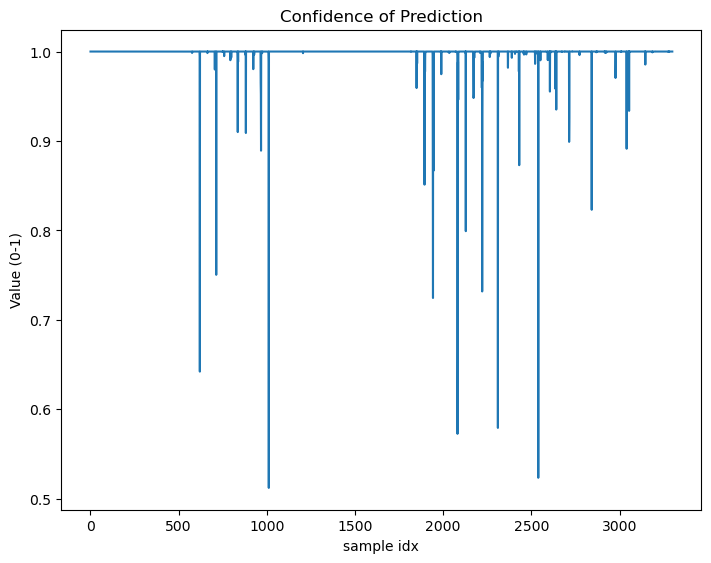

In [109]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)


In [112]:
import sys
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
tf.keras.backend.clear_session()
gc.collect()

37178

In [113]:
#---------------MODEL 5-----------------------------------------#

In [114]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Culex vishnui
No. of files in Culex vishnui = 6710.
No. of files in "/tmp/tmpv1e5f26p/train/Culex vishnui/" should be around 5368.
No. of files in /tmp/tmpv1e5f26p/train/Culex vishnui/ = 5390.
No. of files in "/tmp/tmpv1e5f26p/test/Culex vishnui/" should be around 0.
No. of files in /tmp/tmpv1e5f26p/test/Culex vishnui/ = 0.
No. of files in "/tmp/tmpv1e5f26p/val/Culex vishnui/" should be around 1342.
No. of files in /tmp/tmpv1e5f26p/val/Culex vishnui/ = 1320.
Found Culex quinquefasciatus
No. of files in Culex quinquefasciatus = 7909.
No. of files in "/tmp/tmpv1e5f26p/train/Culex quinquefasciatus/" should be around 6328.
No. of files in /tmp/tmpv1e5f26p/train/Culex quinquefasciatus/ = 6347.
No. of files in "/tmp/tmpv1e5f26p/test/Culex quinquefasciatus/" should be around 0.
No. of files in /tmp/tmpv1e5f26p/test/Culex quinquefasciatus/ = 0.
No. of files in "/tmp/tmpv1e5f26p/val/Culex quinquefasciatus/" should be around 1582.
No. of files in /tmp/tmpv1e5f26p/

((20359, 4883, 0), (13571, 3254, 0))

In [115]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 20359 files belonging to 7 classes.
Found 4883 files belonging to 7 classes.
Found 20359 files belonging to 7 classes.
Found 4883 files belonging to 7 classes.


In [116]:
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/09/21-17:49:44

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40


2022-09-21 17:49:56.198258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1524 of 2545


   3/2545 [..............................] - ETA: 2:47 - loss: 3.6125 - accuracy: 0.0000e+00  

2022-09-21 17:50:02.788566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


2545/2545 [==============================] - 213s 76ms/step - loss: 2.0224 - accuracy: 0.1639 - val_loss: 1.9427 - val_accuracy: 0.1452 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
2545/2545 [==============================] - 179s 70ms/step - loss: 1.9530 - accuracy: 0.1653 - val_loss: 2.0152 - val_accuracy: 0.1622 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
2545/2545 [==============================] - 175s 69ms/step - loss: 1.9686 - accuracy: 0.1574 - val_loss: 1.9798 - val_accuracy: 0.1577 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
2545/2545 [==============================] - 178s 70ms/step - loss: 1.9673 - accuracy: 0.1532 - val_loss: 1.9697 - val_accuracy: 0.1622 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/40
2545/2545 [=========

Maximum test accuracy is at 92.69 %.


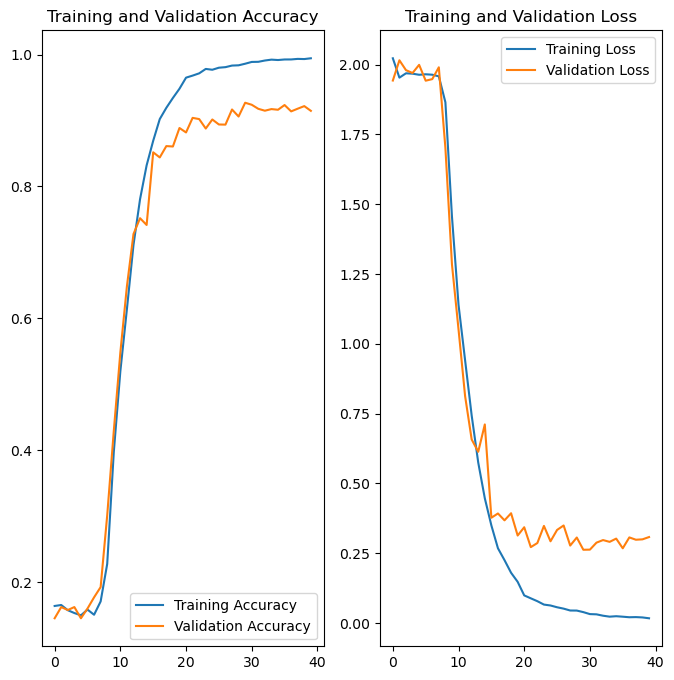

In [117]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [118]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

611/611 [==============================] - 12s 18ms/step
Confusion Matrix
[[764  27   0   0   1   0   0]
 [ 55 654   0   0   0   0   0]
 [  0   0 595   1   0   3   0]
 [  0   0   3 550   1  15   3]
 [  1   0  21   1 575  39 144]
 [  0   0  58   5  17 579   1]
 [  0   0   0   0  19   2 749]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.93      0.96      0.95       792
      Aedes albopictus       0.96      0.92      0.94       709
          Aedes vexans       0.88      0.99      0.93       599
        An tessellatus       0.99      0.96      0.97       572
Culex quinquefasciatus       0.94      0.74      0.82       781
         Culex vishnui       0.91      0.88      0.89       660
                Others       0.84      0.97      0.90       770

              accuracy                           0.91      4883
             macro avg       0.92      0.92      0.92      4883
          weighted avg       0.92      0.9

In [119]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

                                                                                                  
 spatial_dropout2d_10 (SpatialD  (None, 14, 14, 512)  0          ['max_pooling2d_10[0][0]']       
 ropout2D)                                                                                        
                                                                                                  
 conv2d_32 (Conv2D)             (None, 14, 14, 512)  2359808     ['spatial_dropout2d_10[0][0]']   
                                                                                                  
 conv2d_33 (Conv2D)             (None, 14, 14, 512)  2359808     ['conv2d_32[0][0]']              
                                                                                                  
 conv2d_34 (Conv2D)             (None, 14, 14, 512)  2359808     ['conv2d_33[0][0]']              
                                                                                                  
 max_pooli


Epoch 22: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 22/40
2545/2545 [==============================] - 206s 81ms/step - loss: 0.0184 - accuracy: 0.9939 - val_loss: 0.1537 - val_accuracy: 0.9572 - lr: 5.0000e-06

Epoch 23: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 23/40
2545/2545 [==============================] - 206s 81ms/step - loss: 0.0171 - accuracy: 0.9941 - val_loss: 0.1733 - val_accuracy: 0.9490 - lr: 5.0000e-06

Epoch 24: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 24/40
2545/2545 [==============================] - 208s 82ms/step - loss: 0.0143 - accuracy: 0.9949 - val_loss: 0.1872 - val_accuracy: 0.9463 - lr: 5.0000e-06

Epoch 25: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 25/40
2545/2545 [==============================] - 209s 82ms/step - loss: 0.0132 - accuracy: 0.9956 - val_loss: 0.1614 - val_accuracy: 0.9578 - lr: 5.0000e-06

Epoch 26: Learn

Maximum test accuracy is at 96.11 %.


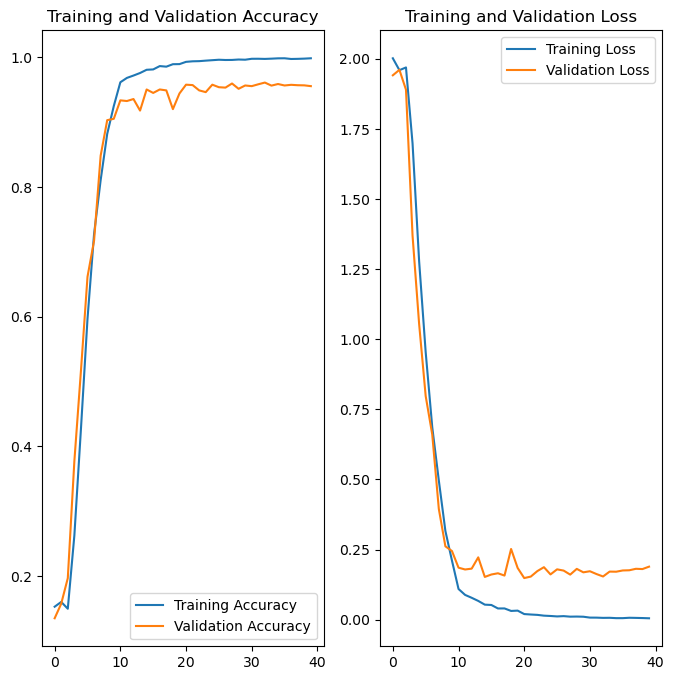

In [120]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [121]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

611/611 [==============================] - 14s 22ms/step
Confusion Matrix
[[783   8   0   0   0   1   0]
 [ 45 664   0   0   0   0   0]
 [  0   0 595   0   0   4   0]
 [  0   0   1 552   0  16   3]
 [  0   0   5   3 680  32  61]
 [  0   0  24   1   6 629   0]
 [  0   0   0   0   7   0 763]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.95      0.99      0.97       792
      Aedes albopictus       0.99      0.94      0.96       709
          Aedes vexans       0.95      0.99      0.97       599
        An tessellatus       0.99      0.97      0.98       572
Culex quinquefasciatus       0.98      0.87      0.92       781
         Culex vishnui       0.92      0.95      0.94       660
                Others       0.92      0.99      0.96       770

              accuracy                           0.96      4883
             macro avg       0.96      0.96      0.96      4883
          weighted avg       0.96      0.9

In [122]:
model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_35 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

 conv2d_55 (Conv2D)             (None, 28, 28, 512)  1180160     ['spatial_dropout2d_18[0][0]']   
                                                                                                  
 conv2d_43 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_42[0][0]']              
                                                                                                  
 conv2d_56 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_55[0][0]']              
                                                                                                  
 conv2d_44 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_43[0][0]']              
                                                                                                  
 conv2d_57 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_56[0][0]']              
                                                                                                  
 max_pooli

Epoch 12/40
2545/2545 [==============================] - 240s 94ms/step - loss: 0.0115 - accuracy: 0.9958 - val_loss: 0.1765 - val_accuracy: 0.9535 - lr: 1.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 13/40
2545/2545 [==============================] - 241s 95ms/step - loss: 0.0136 - accuracy: 0.9954 - val_loss: 0.1653 - val_accuracy: 0.9580 - lr: 1.0000e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 14/40
2545/2545 [==============================] - 239s 94ms/step - loss: 0.0088 - accuracy: 0.9972 - val_loss: 0.1513 - val_accuracy: 0.9644 - lr: 1.0000e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 15/40
2545/2545 [==============================] - 236s 93ms/step - loss: 0.0091 - accuracy: 0.9966 - val_loss: 0.1646 - val_accuracy: 0.9615 - lr: 1.0000e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 16/40
2545

Maximum test accuracy is at 97.09 %.


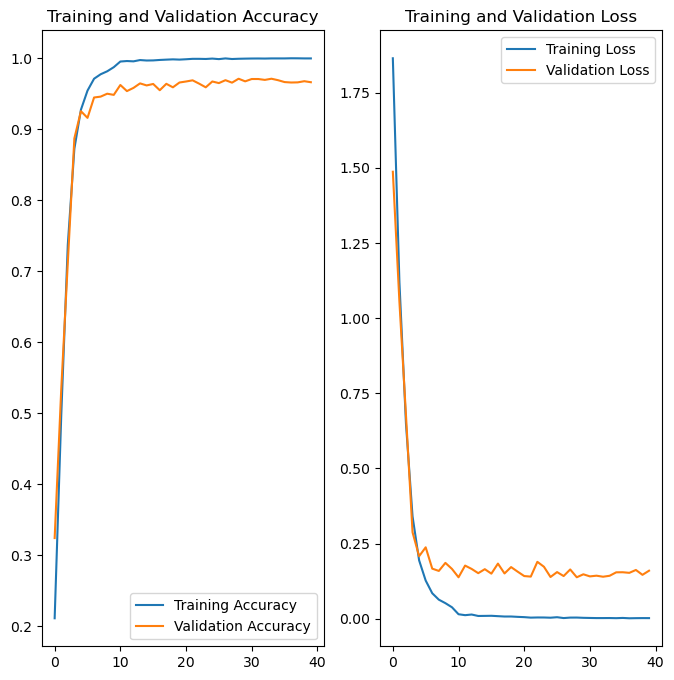

In [123]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [124]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

611/611 [==============================] - 16s 26ms/step
Confusion Matrix
[[781  11   0   0   0   0   0]
 [ 12 697   0   0   0   0   0]
 [  0   0 593   2   0   4   0]
 [  0   0   0 571   0   1   0]
 [  0   0   5   2 665  53  56]
 [  0   0  10   0   2 648   0]
 [  0   0   0   1   7   0 762]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.98      0.99      0.99       792
      Aedes albopictus       0.98      0.98      0.98       709
          Aedes vexans       0.98      0.99      0.98       599
        An tessellatus       0.99      1.00      0.99       572
Culex quinquefasciatus       0.99      0.85      0.91       781
         Culex vishnui       0.92      0.98      0.95       660
                Others       0.93      0.99      0.96       770

              accuracy                           0.97      4883
             macro avg       0.97      0.97      0.97      4883
          weighted avg       0.97      0.9

In [125]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 13571 files belonging to 7 classes.
Found 3254 files belonging to 7 classes.
Found 13571 files belonging to 7 classes.
Found 3254 files belonging to 7 classes.
Found 13571 files belonging to 7 classes.
Found 3254 files belonging to 7 classes.


In [126]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

407/407 [==============================] - 12s 28ms/step


In [127]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
849/849 [==============================] - 4s 4ms/step - loss: 0.2939 - accuracy: 0.9139
Epoch 2/20
849/849 [==============================] - 4s 5ms/step - loss: 0.0052 - accuracy: 0.9998
Epoch 3/20
849/849 [==============================] - 4s 5ms/step - loss: 0.0023 - accuracy: 0.9999
Epoch 4/20
849/849 [==============================] - 4s 4ms/step - loss: 0.0015 - accuracy: 0.9999
Epoch 5/20
849/849 [==============================] - 4s 5ms/step - loss: 0.0012 - accuracy: 0.9999
Epoch 6/20
849/849 [==============================] - 4s 5ms/step - loss: 0.0010 - accuracy: 0.9999
Epoch 7/20
849/849 [==============================] - 4s 5ms/step - loss: 8.5339e-04 - accuracy: 0.9999
Epoch 8/20
849/849 [==============================] - 4s 4ms/step - loss: 7.8691e-04 - accuracy: 0.9999
Epoch 9/20
849/849 [==============================] - 4s 4ms/step - loss: 6.6895e-04 - accuracy: 0.9999
Epoch 10/20
849/849 [==============================] - 4s 4ms/step - loss: 6.3144e-04 - 

102/102 [==============================] - 0s 2ms/step


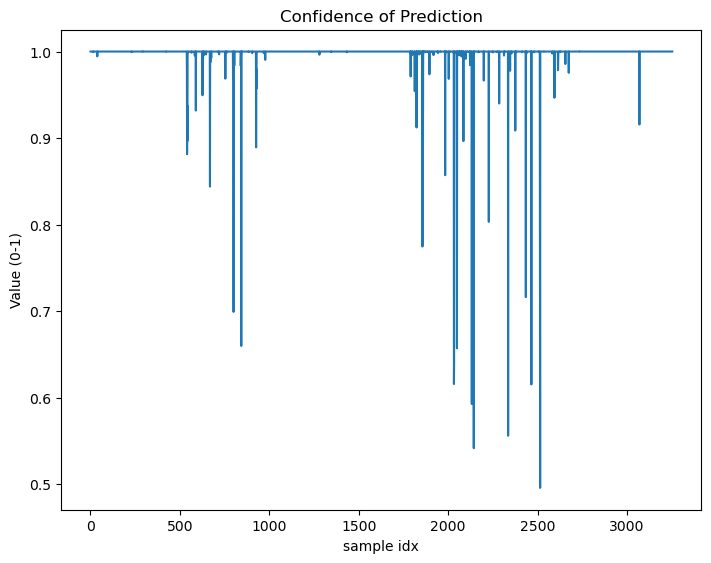

In [128]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)
#----------------------------------


In [129]:
import sys
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
tf.keras.backend.clear_session()
gc.collect()

28531

In [130]:
#---------------MODEL6-----------------------------------------#

In [131]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Culex vishnui
No. of files in Culex vishnui = 6710.
No. of files in "/tmp/tmpf_b702si/train/Culex vishnui/" should be around 5368.
No. of files in /tmp/tmpf_b702si/train/Culex vishnui/ = 5390.
No. of files in "/tmp/tmpf_b702si/test/Culex vishnui/" should be around 0.
No. of files in /tmp/tmpf_b702si/test/Culex vishnui/ = 0.
No. of files in "/tmp/tmpf_b702si/val/Culex vishnui/" should be around 1342.
No. of files in /tmp/tmpf_b702si/val/Culex vishnui/ = 1320.
Found Culex quinquefasciatus
No. of files in Culex quinquefasciatus = 7909.
No. of files in "/tmp/tmpf_b702si/train/Culex quinquefasciatus/" should be around 6328.
No. of files in /tmp/tmpf_b702si/train/Culex quinquefasciatus/ = 6336.
No. of files in "/tmp/tmpf_b702si/test/Culex quinquefasciatus/" should be around 0.
No. of files in /tmp/tmpf_b702si/test/Culex quinquefasciatus/ = 0.
No. of files in "/tmp/tmpf_b702si/val/Culex quinquefasciatus/" should be around 1582.
No. of files in /tmp/tmpf_b702si/

((20349, 4894, 0), (13564, 3262, 0))

In [132]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 20349 files belonging to 7 classes.
Found 4894 files belonging to 7 classes.
Found 20349 files belonging to 7 classes.
Found 4894 files belonging to 7 classes.


In [133]:
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/09/22-01:05:57

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40


2022-09-22 01:06:09.377840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1543 of 2544


   3/2544 [..............................] - ETA: 2:38 - loss: 3.4109 - accuracy: 0.3333  

2022-09-22 01:06:15.841149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


2544/2544 [==============================] - 202s 72ms/step - loss: 1.8952 - accuracy: 0.1933 - val_loss: 1.9070 - val_accuracy: 0.2266 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
2544/2544 [==============================] - 179s 70ms/step - loss: 1.2968 - accuracy: 0.4183 - val_loss: 0.9131 - val_accuracy: 0.6206 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
2544/2544 [==============================] - 173s 68ms/step - loss: 0.8763 - accuracy: 0.6328 - val_loss: 0.6240 - val_accuracy: 0.7546 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
2544/2544 [==============================] - 177s 70ms/step - loss: 0.6242 - accuracy: 0.7548 - val_loss: 0.4637 - val_accuracy: 0.8228 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/40
2544/2544 [=========

Maximum test accuracy is at 97.3 %.


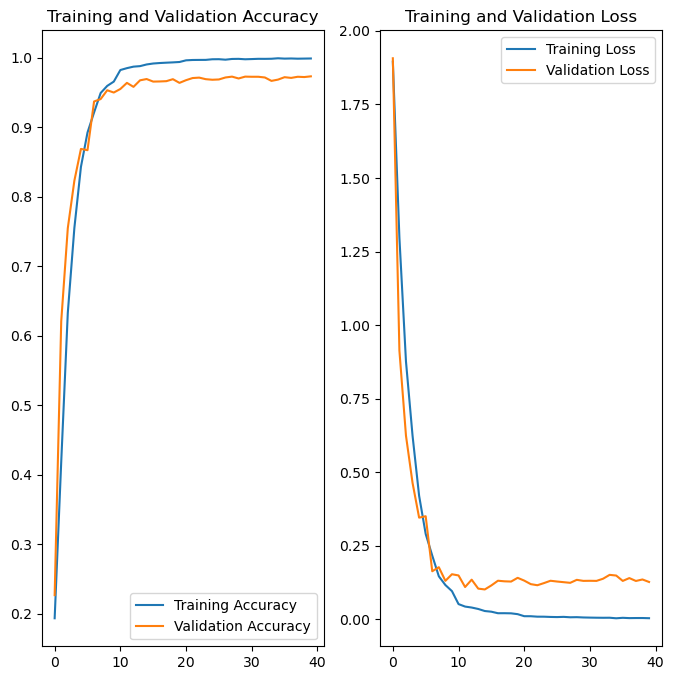

In [134]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [135]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

612/612 [==============================] - 12s 19ms/step
Confusion Matrix
[[784  24   0   0   0   0   0]
 [ 22 671   0   0   0   0   0]
 [  0   0 614   0   0   2   0]
 [  0   0   0 561   0   0   0]
 [  0   0   0   0 735  13  38]
 [  0   0   4   0   1 654   1]
 [  6   0   0   0  21   0 743]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.97      0.97      0.97       808
      Aedes albopictus       0.97      0.97      0.97       693
          Aedes vexans       0.99      1.00      1.00       616
        An tessellatus       1.00      1.00      1.00       561
Culex quinquefasciatus       0.97      0.94      0.95       786
         Culex vishnui       0.98      0.99      0.98       660
                Others       0.95      0.96      0.96       770

              accuracy                           0.97      4894
             macro avg       0.97      0.98      0.97      4894
          weighted avg       0.97      0.9

In [136]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

                                                                                                  
 spatial_dropout2d_10 (SpatialD  (None, 14, 14, 512)  0          ['max_pooling2d_10[0][0]']       
 ropout2D)                                                                                        
                                                                                                  
 conv2d_32 (Conv2D)             (None, 14, 14, 512)  2359808     ['spatial_dropout2d_10[0][0]']   
                                                                                                  
 conv2d_33 (Conv2D)             (None, 14, 14, 512)  2359808     ['conv2d_32[0][0]']              
                                                                                                  
 conv2d_34 (Conv2D)             (None, 14, 14, 512)  2359808     ['conv2d_33[0][0]']              
                                                                                                  
 max_pooli


Epoch 22: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 22/40
2544/2544 [==============================] - 208s 82ms/step - loss: 0.0093 - accuracy: 0.9968 - val_loss: 0.0969 - val_accuracy: 0.9747 - lr: 5.0000e-06

Epoch 23: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 23/40
2544/2544 [==============================] - 210s 83ms/step - loss: 0.0082 - accuracy: 0.9971 - val_loss: 0.1006 - val_accuracy: 0.9749 - lr: 5.0000e-06

Epoch 24: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 24/40
2544/2544 [==============================] - 211s 83ms/step - loss: 0.0088 - accuracy: 0.9972 - val_loss: 0.0792 - val_accuracy: 0.9779 - lr: 5.0000e-06

Epoch 25: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 25/40
2544/2544 [==============================] - 202s 79ms/step - loss: 0.0066 - accuracy: 0.9979 - val_loss: 0.0998 - val_accuracy: 0.9730 - lr: 5.0000e-06

Epoch 26: Learn

Maximum test accuracy is at 97.96 %.


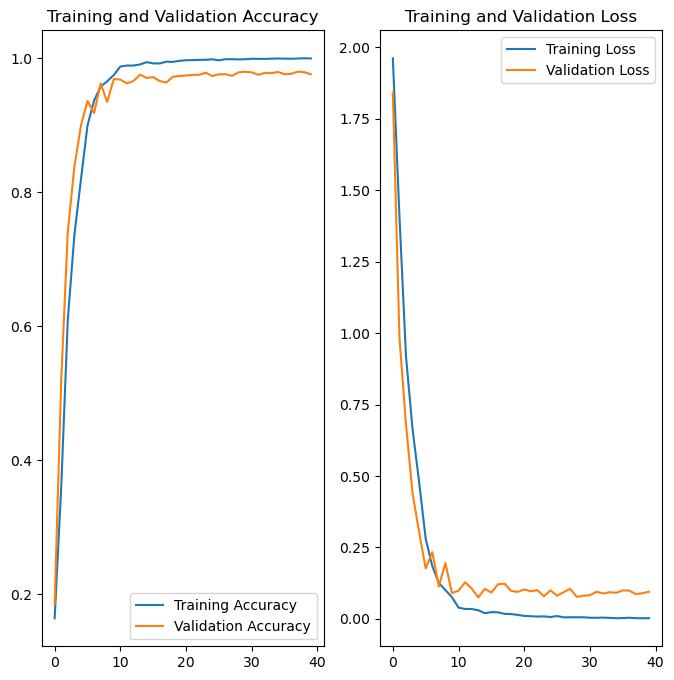

In [137]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [138]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

612/612 [==============================] - 15s 23ms/step
Confusion Matrix
[[795  13   0   0   0   0   0]
 [ 47 646   0   0   0   0   0]
 [  2   0 611   1   1   1   0]
 [  0   0   0 561   0   0   0]
 [  0   0   0   4 751  18  13]
 [  0   0   0   2   1 657   0]
 [  0   0   0   1  15   0 754]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.94      0.98      0.96       808
      Aedes albopictus       0.98      0.93      0.96       693
          Aedes vexans       1.00      0.99      1.00       616
        An tessellatus       0.99      1.00      0.99       561
Culex quinquefasciatus       0.98      0.96      0.97       786
         Culex vishnui       0.97      1.00      0.98       660
                Others       0.98      0.98      0.98       770

              accuracy                           0.98      4894
             macro avg       0.98      0.98      0.98      4894
          weighted avg       0.98      0.9

In [139]:
model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_35 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

 conv2d_55 (Conv2D)             (None, 28, 28, 512)  1180160     ['spatial_dropout2d_18[0][0]']   
                                                                                                  
 conv2d_43 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_42[0][0]']              
                                                                                                  
 conv2d_56 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_55[0][0]']              
                                                                                                  
 conv2d_44 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_43[0][0]']              
                                                                                                  
 conv2d_57 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_56[0][0]']              
                                                                                                  
 max_pooli

Epoch 12/40
2544/2544 [==============================] - 246s 97ms/step - loss: 0.0176 - accuracy: 0.9943 - val_loss: 0.0921 - val_accuracy: 0.9734 - lr: 1.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 13/40
2544/2544 [==============================] - 245s 96ms/step - loss: 0.0153 - accuracy: 0.9951 - val_loss: 0.0953 - val_accuracy: 0.9734 - lr: 1.0000e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 14/40
2544/2544 [==============================] - 244s 96ms/step - loss: 0.0130 - accuracy: 0.9957 - val_loss: 0.1072 - val_accuracy: 0.9696 - lr: 1.0000e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 15/40
2544/2544 [==============================] - 237s 93ms/step - loss: 0.0132 - accuracy: 0.9953 - val_loss: 0.0921 - val_accuracy: 0.9714 - lr: 1.0000e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 16/40
2544

Maximum test accuracy is at 97.71 %.


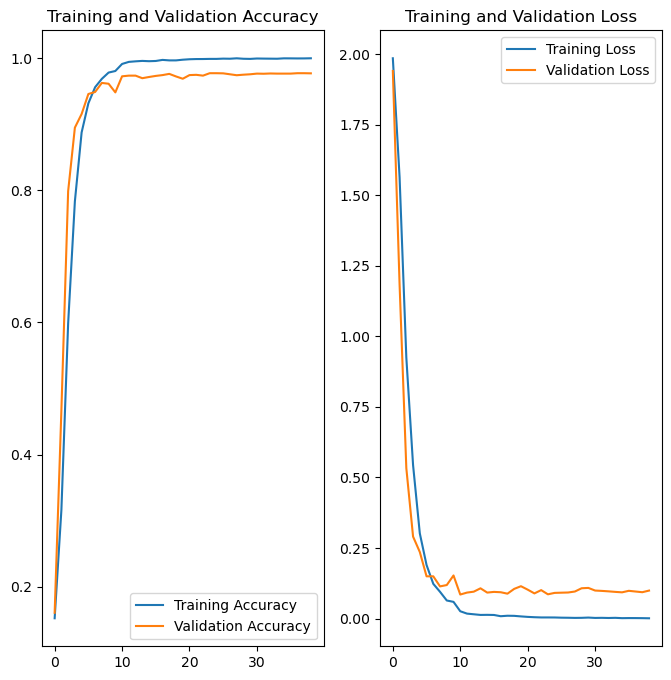

In [140]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [141]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----



612/612 [==============================] - 16s 26ms/step
Confusion Matrix
[[797  11   0   0   0   0   0]
 [ 27 666   0   0   0   0   0]
 [  1   0 612   1   0   2   0]
 [  0   0   0 560   1   0   0]
 [  0   0   0   0 741  20  25]
 [  0   0   3   0   1 656   0]
 [  0   0   0   2  18   0 750]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.97      0.99      0.98       808
      Aedes albopictus       0.98      0.96      0.97       693
          Aedes vexans       1.00      0.99      0.99       616
        An tessellatus       0.99      1.00      1.00       561
Culex quinquefasciatus       0.97      0.94      0.96       786
         Culex vishnui       0.97      0.99      0.98       660
                Others       0.97      0.97      0.97       770

              accuracy                           0.98      4894
             macro avg       0.98      0.98      0.98      4894
          weighted avg       0.98      0.9

In [142]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 13564 files belonging to 7 classes.
Found 3262 files belonging to 7 classes.
Found 13564 files belonging to 7 classes.
Found 3262 files belonging to 7 classes.
Found 13564 files belonging to 7 classes.
Found 3262 files belonging to 7 classes.


In [143]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

408/408 [==============================] - 11s 27ms/step


In [144]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
848/848 [==============================] - 4s 4ms/step - loss: 0.2334 - accuracy: 0.9488
Epoch 2/20
848/848 [==============================] - 4s 5ms/step - loss: 0.0035 - accuracy: 0.9999
Epoch 3/20
848/848 [==============================] - 4s 5ms/step - loss: 0.0013 - accuracy: 0.9999
Epoch 4/20
848/848 [==============================] - 4s 4ms/step - loss: 6.5199e-04 - accuracy: 0.9999
Epoch 5/20
848/848 [==============================] - 4s 4ms/step - loss: 3.7169e-04 - accuracy: 0.9999
Epoch 6/20
848/848 [==============================] - 4s 4ms/step - loss: 1.9749e-04 - accuracy: 1.0000
Epoch 7/20
848/848 [==============================] - 4s 4ms/step - loss: 1.2181e-04 - accuracy: 1.0000
Epoch 8/20
848/848 [==============================] - 4s 4ms/step - loss: 7.1979e-05 - accuracy: 1.0000
Epoch 9/20
848/848 [==============================] - 4s 4ms/step - loss: 4.5150e-05 - accuracy: 1.0000
Epoch 10/20
848/848 [==============================] - 4s 4ms/step - loss: 2

102/102 [==============================] - 0s 2ms/step


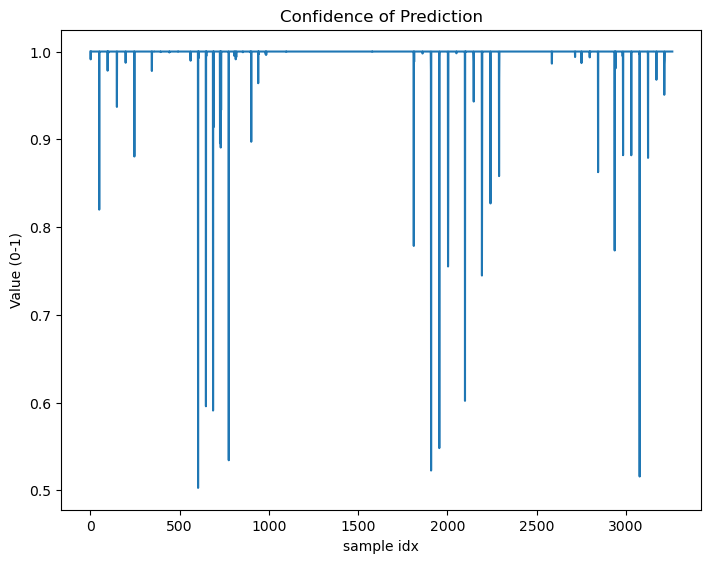

In [145]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)
#----------------------------------


In [146]:
import sys
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
tf.keras.backend.clear_session()
gc.collect()

28566

In [147]:
#---------------MODEL7-----------------------------------------#

In [148]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Culex vishnui
No. of files in Culex vishnui = 6710.
No. of files in "/tmp/tmpyj_vy4uc/train/Culex vishnui/" should be around 5368.
No. of files in /tmp/tmpyj_vy4uc/train/Culex vishnui/ = 5412.
No. of files in "/tmp/tmpyj_vy4uc/test/Culex vishnui/" should be around 0.
No. of files in /tmp/tmpyj_vy4uc/test/Culex vishnui/ = 0.
No. of files in "/tmp/tmpyj_vy4uc/val/Culex vishnui/" should be around 1342.
No. of files in /tmp/tmpyj_vy4uc/val/Culex vishnui/ = 1298.
Found Culex quinquefasciatus
No. of files in Culex quinquefasciatus = 7909.
No. of files in "/tmp/tmpyj_vy4uc/train/Culex quinquefasciatus/" should be around 6328.
No. of files in /tmp/tmpyj_vy4uc/train/Culex quinquefasciatus/ = 6435.
No. of files in "/tmp/tmpyj_vy4uc/test/Culex quinquefasciatus/" should be around 0.
No. of files in /tmp/tmpyj_vy4uc/test/Culex quinquefasciatus/ = 0.
No. of files in "/tmp/tmpyj_vy4uc/val/Culex quinquefasciatus/" should be around 1582.
No. of files in /tmp/tmpyj_vy4uc/

((20348, 4893, 0), (13565, 3261, 0))

In [149]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 20348 files belonging to 7 classes.
Found 4893 files belonging to 7 classes.
Found 20348 files belonging to 7 classes.
Found 4893 files belonging to 7 classes.


In [150]:
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/09/22-08:16:35

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40


2022-09-22 08:16:47.122817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1558 of 2544


   3/2544 [..............................] - ETA: 2:37 - loss: 3.2104 - accuracy: 0.0000e+00  

2022-09-22 08:16:53.452010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


2544/2544 [==============================] - 199s 71ms/step - loss: 1.9847 - accuracy: 0.1482 - val_loss: 1.9599 - val_accuracy: 0.1506 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
2544/2544 [==============================] - 179s 70ms/step - loss: 1.9432 - accuracy: 0.1541 - val_loss: 1.9329 - val_accuracy: 0.1686 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
2544/2544 [==============================] - 176s 69ms/step - loss: 1.7823 - accuracy: 0.2325 - val_loss: 1.5052 - val_accuracy: 0.3372 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
2544/2544 [==============================] - 175s 69ms/step - loss: 1.3718 - accuracy: 0.3796 - val_loss: 1.0982 - val_accuracy: 0.4974 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/40
2544/2544 [=========

Maximum test accuracy is at 94.75 %.


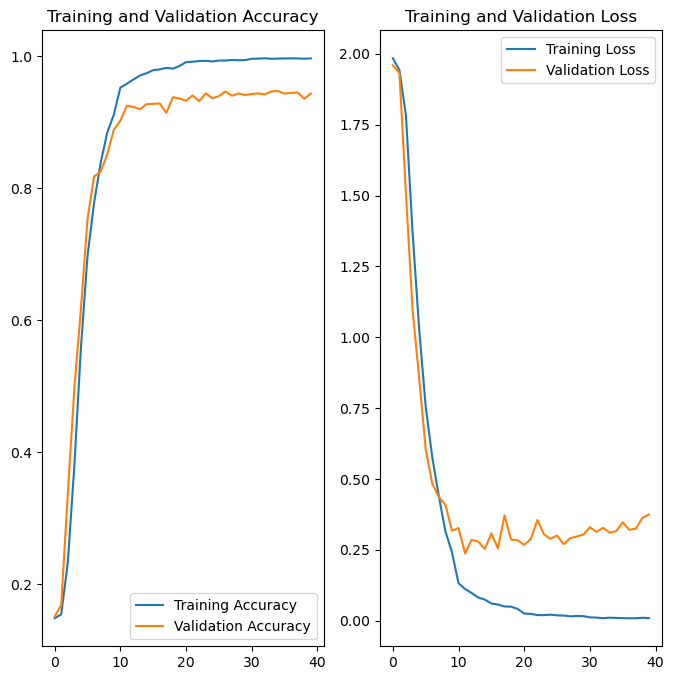

In [151]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [152]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

612/612 [==============================] - 12s 19ms/step
Confusion Matrix
[[810  12   0   2   0   1   0]
 [ 16 693   0   0   0   0   0]
 [  0   0 628   3   0   1   0]
 [  0   0   1 565   0   0   0]
 [  1   0   8   1 534  12 181]
 [  0   0  15   8  10 615   1]
 [  0   0   0   0   3   0 772]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.98      0.98      0.98       825
      Aedes albopictus       0.98      0.98      0.98       709
          Aedes vexans       0.96      0.99      0.98       632
        An tessellatus       0.98      1.00      0.99       566
Culex quinquefasciatus       0.98      0.72      0.83       737
         Culex vishnui       0.98      0.95      0.96       649
                Others       0.81      1.00      0.89       775

              accuracy                           0.94      4893
             macro avg       0.95      0.95      0.94      4893
          weighted avg       0.95      0.9

In [153]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

                                                                                                  
 spatial_dropout2d_10 (SpatialD  (None, 14, 14, 512)  0          ['max_pooling2d_10[0][0]']       
 ropout2D)                                                                                        
                                                                                                  
 conv2d_32 (Conv2D)             (None, 14, 14, 512)  2359808     ['spatial_dropout2d_10[0][0]']   
                                                                                                  
 conv2d_33 (Conv2D)             (None, 14, 14, 512)  2359808     ['conv2d_32[0][0]']              
                                                                                                  
 conv2d_34 (Conv2D)             (None, 14, 14, 512)  2359808     ['conv2d_33[0][0]']              
                                                                                                  
 max_pooli


Epoch 22: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 22/40
2544/2544 [==============================] - 209s 82ms/step - loss: 0.0344 - accuracy: 0.9881 - val_loss: 0.2906 - val_accuracy: 0.9346 - lr: 5.0000e-06

Epoch 23: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 23/40
2544/2544 [==============================] - 213s 84ms/step - loss: 0.0303 - accuracy: 0.9892 - val_loss: 0.2712 - val_accuracy: 0.9418 - lr: 5.0000e-06

Epoch 24: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 24/40
2544/2544 [==============================] - 212s 83ms/step - loss: 0.0281 - accuracy: 0.9903 - val_loss: 0.3023 - val_accuracy: 0.9297 - lr: 5.0000e-06

Epoch 25: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 25/40
2544/2544 [==============================] - 207s 81ms/step - loss: 0.0248 - accuracy: 0.9917 - val_loss: 0.2387 - val_accuracy: 0.9438 - lr: 5.0000e-06

Epoch 26: Learn

Maximum test accuracy is at 94.89 %.


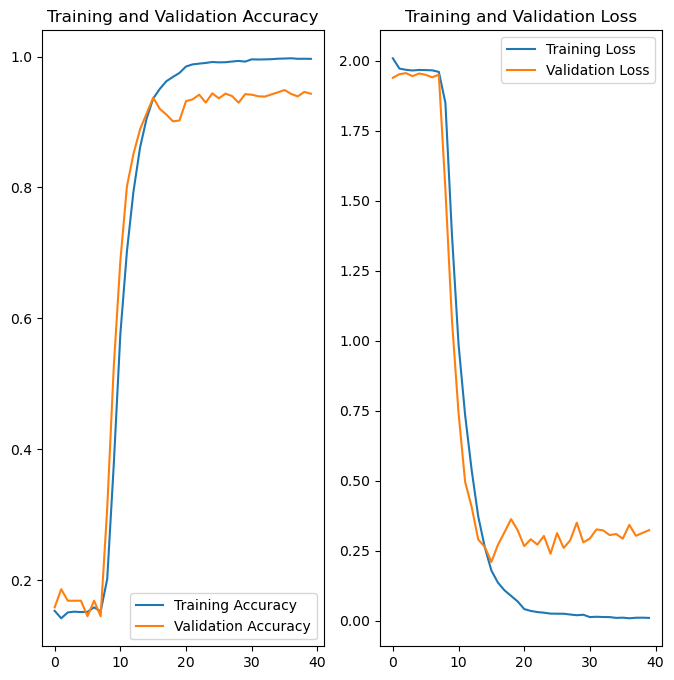

In [154]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [155]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

612/612 [==============================] - 14s 22ms/step
Confusion Matrix
[[820   0   2   1   0   2   0]
 [ 78 631   0   0   0   0   0]
 [  0   0 622   1   1   8   0]
 [  0   0   0 566   0   0   0]
 [  0   0   2   1 576  31 127]
 [  0   0   3   0   4 642   0]
 [  0   0   0   0  17   0 758]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.91      0.99      0.95       825
      Aedes albopictus       1.00      0.89      0.94       709
          Aedes vexans       0.99      0.98      0.99       632
        An tessellatus       0.99      1.00      1.00       566
Culex quinquefasciatus       0.96      0.78      0.86       737
         Culex vishnui       0.94      0.99      0.96       649
                Others       0.86      0.98      0.91       775

              accuracy                           0.94      4893
             macro avg       0.95      0.95      0.95      4893
          weighted avg       0.95      0.9

In [156]:
model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_35 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

 conv2d_55 (Conv2D)             (None, 28, 28, 512)  1180160     ['spatial_dropout2d_18[0][0]']   
                                                                                                  
 conv2d_43 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_42[0][0]']              
                                                                                                  
 conv2d_56 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_55[0][0]']              
                                                                                                  
 conv2d_44 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_43[0][0]']              
                                                                                                  
 conv2d_57 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_56[0][0]']              
                                                                                                  
 max_pooli

Epoch 12/40
2544/2544 [==============================] - 238s 93ms/step - loss: 0.0124 - accuracy: 0.9957 - val_loss: 0.3009 - val_accuracy: 0.9436 - lr: 1.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 13/40
2544/2544 [==============================] - 237s 93ms/step - loss: 0.0127 - accuracy: 0.9961 - val_loss: 0.2755 - val_accuracy: 0.9418 - lr: 1.0000e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 14/40
2544/2544 [==============================] - 238s 94ms/step - loss: 0.0096 - accuracy: 0.9973 - val_loss: 0.3124 - val_accuracy: 0.9497 - lr: 1.0000e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 15/40
2544/2544 [==============================] - 241s 95ms/step - loss: 0.0090 - accuracy: 0.9972 - val_loss: 0.2780 - val_accuracy: 0.9448 - lr: 1.0000e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 16/40
2544

Maximum test accuracy is at 95.57 %.


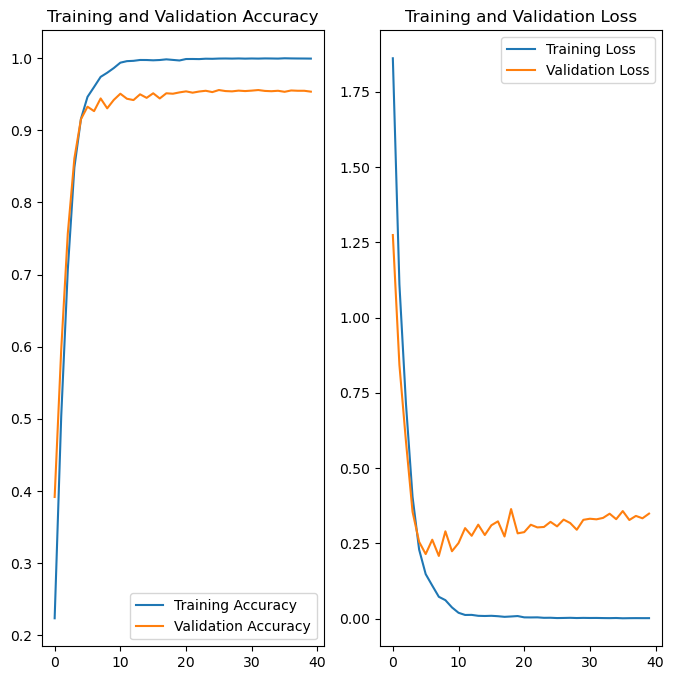

In [157]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [158]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

612/612 [==============================] - 15s 25ms/step
Confusion Matrix
[[822   1   0   2   0   0   0]
 [ 23 686   0   0   0   0   0]
 [  0   0 630   0   0   2   0]
 [  0   0   0 565   0   1   0]
 [  1   0  14   3 551  35 133]
 [  0   0   8   0   0 641   0]
 [  0   0   0   0   5   0 770]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.97      1.00      0.98       825
      Aedes albopictus       1.00      0.97      0.98       709
          Aedes vexans       0.97      1.00      0.98       632
        An tessellatus       0.99      1.00      0.99       566
Culex quinquefasciatus       0.99      0.75      0.85       737
         Culex vishnui       0.94      0.99      0.97       649
                Others       0.85      0.99      0.92       775

              accuracy                           0.95      4893
             macro avg       0.96      0.96      0.95      4893
          weighted avg       0.96      0.9

In [159]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 13565 files belonging to 7 classes.
Found 3261 files belonging to 7 classes.
Found 13565 files belonging to 7 classes.
Found 3261 files belonging to 7 classes.
Found 13565 files belonging to 7 classes.
Found 3261 files belonging to 7 classes.


In [160]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

408/408 [==============================] - 11s 27ms/step


In [161]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
848/848 [==============================] - 4s 4ms/step - loss: 0.2661 - accuracy: 0.9440
Epoch 2/20
848/848 [==============================] - 4s 5ms/step - loss: 0.0047 - accuracy: 0.9999
Epoch 3/20
848/848 [==============================] - 4s 5ms/step - loss: 0.0021 - accuracy: 0.9999
Epoch 4/20
848/848 [==============================] - 4s 5ms/step - loss: 0.0014 - accuracy: 0.9998
Epoch 5/20
848/848 [==============================] - 4s 4ms/step - loss: 0.0012 - accuracy: 0.9998
Epoch 6/20
848/848 [==============================] - 4s 5ms/step - loss: 9.4783e-04 - accuracy: 0.9999
Epoch 7/20
848/848 [==============================] - 4s 4ms/step - loss: 8.6025e-04 - accuracy: 0.9999
Epoch 8/20
848/848 [==============================] - 4s 4ms/step - loss: 7.1024e-04 - accuracy: 0.9999
Epoch 9/20
848/848 [==============================] - 4s 4ms/step - loss: 7.2117e-04 - accuracy: 0.9999
Epoch 10/20
848/848 [==============================] - 4s 5ms/step - loss: 6.2791e-0

102/102 [==============================] - 0s 2ms/step


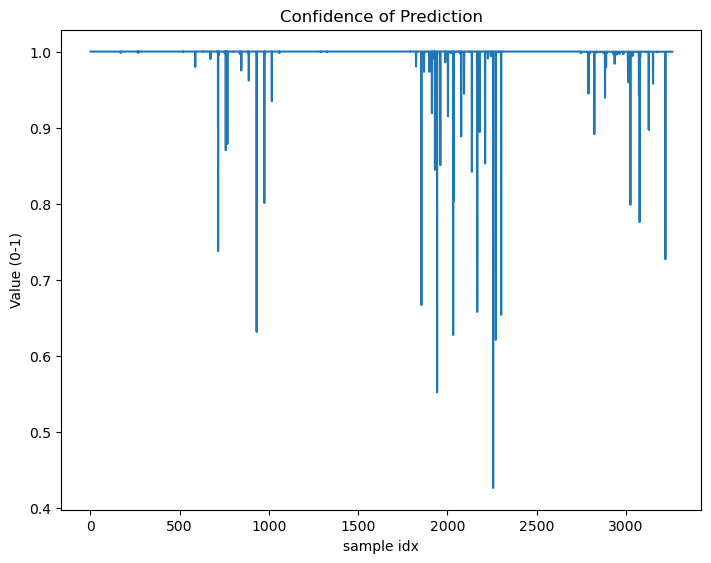

In [162]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)
#----------------------------------


In [163]:
import sys
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
tf.keras.backend.clear_session()
gc.collect()

28599

In [164]:
#---------------MODEL8-----------------------------------------#

In [165]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Culex vishnui
No. of files in Culex vishnui = 6710.
No. of files in "/tmp/tmpwnwf2dcj/train/Culex vishnui/" should be around 5368.
No. of files in /tmp/tmpwnwf2dcj/train/Culex vishnui/ = 5379.
No. of files in "/tmp/tmpwnwf2dcj/test/Culex vishnui/" should be around 0.
No. of files in /tmp/tmpwnwf2dcj/test/Culex vishnui/ = 0.
No. of files in "/tmp/tmpwnwf2dcj/val/Culex vishnui/" should be around 1342.
No. of files in /tmp/tmpwnwf2dcj/val/Culex vishnui/ = 1331.
Found Culex quinquefasciatus
No. of files in Culex quinquefasciatus = 7909.
No. of files in "/tmp/tmpwnwf2dcj/train/Culex quinquefasciatus/" should be around 6328.
No. of files in /tmp/tmpwnwf2dcj/train/Culex quinquefasciatus/ = 6391.
No. of files in "/tmp/tmpwnwf2dcj/test/Culex quinquefasciatus/" should be around 0.
No. of files in /tmp/tmpwnwf2dcj/test/Culex quinquefasciatus/ = 0.
No. of files in "/tmp/tmpwnwf2dcj/val/Culex quinquefasciatus/" should be around 1582.
No. of files in /tmp/tmpwnwf2dcj/

((20337, 4904, 0), (13557, 3269, 0))

In [166]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 20337 files belonging to 7 classes.
Found 4904 files belonging to 7 classes.
Found 20337 files belonging to 7 classes.
Found 4904 files belonging to 7 classes.


In [167]:
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/09/22-15:32:58

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40


2022-09-22 15:33:10.185642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1554 of 2543


   3/2543 [..............................] - ETA: 2:30 - loss: 4.0071 - accuracy: 0.0000e+00  

2022-09-22 15:33:16.289139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


2543/2543 [==============================] - 198s 71ms/step - loss: 2.0261 - accuracy: 0.1432 - val_loss: 1.9687 - val_accuracy: 0.1446 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
2543/2543 [==============================] - 177s 69ms/step - loss: 1.9668 - accuracy: 0.1444 - val_loss: 1.9761 - val_accuracy: 0.1446 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
2543/2543 [==============================] - 167s 66ms/step - loss: 1.9652 - accuracy: 0.1532 - val_loss: 1.9691 - val_accuracy: 0.1503 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
2543/2543 [==============================] - 177s 70ms/step - loss: 1.9629 - accuracy: 0.1454 - val_loss: 1.9353 - val_accuracy: 0.1866 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/40
2543/2543 [=========

Maximum test accuracy is at 95.96 %.


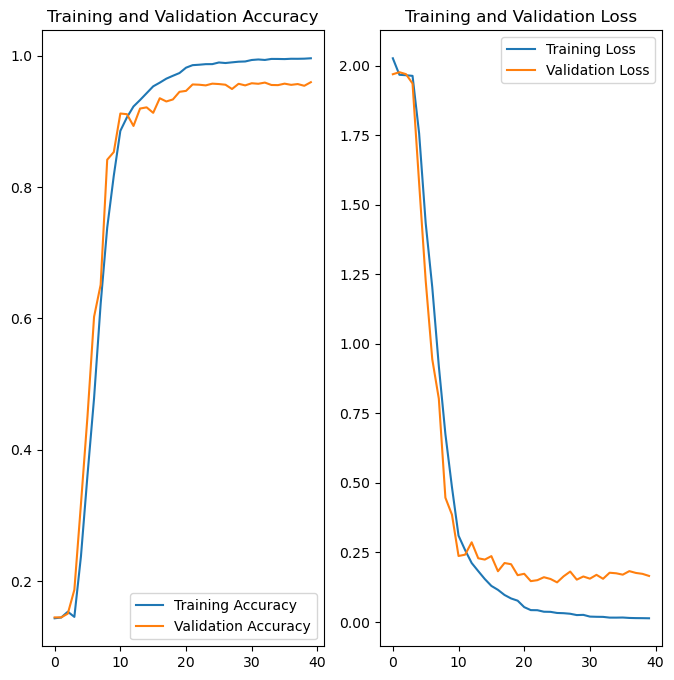

In [168]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [169]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

613/613 [==============================] - 13s 20ms/step
Confusion Matrix
[[800  21   0   1   2   1   0]
 [  4 705   0   0   0   0   0]
 [  0   0 633   0   1   8   1]
 [  0   0   1 562   0   2   1]
 [  2   0   3   3 665  28  58]
 [  0   0  26   4   5 630   0]
 [  0   0   0   2  24   0 711]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.99      0.97      0.98       825
      Aedes albopictus       0.97      0.99      0.98       709
          Aedes vexans       0.95      0.98      0.97       643
        An tessellatus       0.98      0.99      0.99       566
Culex quinquefasciatus       0.95      0.88      0.91       759
         Culex vishnui       0.94      0.95      0.94       665
                Others       0.92      0.96      0.94       737

              accuracy                           0.96      4904
             macro avg       0.96      0.96      0.96      4904
          weighted avg       0.96      0.9

In [170]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

                                                                                                  
 spatial_dropout2d_10 (SpatialD  (None, 14, 14, 512)  0          ['max_pooling2d_10[0][0]']       
 ropout2D)                                                                                        
                                                                                                  
 conv2d_32 (Conv2D)             (None, 14, 14, 512)  2359808     ['spatial_dropout2d_10[0][0]']   
                                                                                                  
 conv2d_33 (Conv2D)             (None, 14, 14, 512)  2359808     ['conv2d_32[0][0]']              
                                                                                                  
 conv2d_34 (Conv2D)             (None, 14, 14, 512)  2359808     ['conv2d_33[0][0]']              
                                                                                                  
 max_pooli


Epoch 22: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 22/40
2543/2543 [==============================] - 205s 81ms/step - loss: 0.0110 - accuracy: 0.9966 - val_loss: 0.1153 - val_accuracy: 0.9755 - lr: 5.0000e-06

Epoch 23: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 23/40
2543/2543 [==============================] - 211s 83ms/step - loss: 0.0107 - accuracy: 0.9963 - val_loss: 0.1239 - val_accuracy: 0.9727 - lr: 5.0000e-06

Epoch 24: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 24/40
2543/2543 [==============================] - 207s 81ms/step - loss: 0.0108 - accuracy: 0.9959 - val_loss: 0.1190 - val_accuracy: 0.9749 - lr: 5.0000e-06

Epoch 25: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 25/40
2543/2543 [==============================] - 210s 82ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.1323 - val_accuracy: 0.9757 - lr: 5.0000e-06

Epoch 26: Learn

Maximum test accuracy is at 98.06 %.


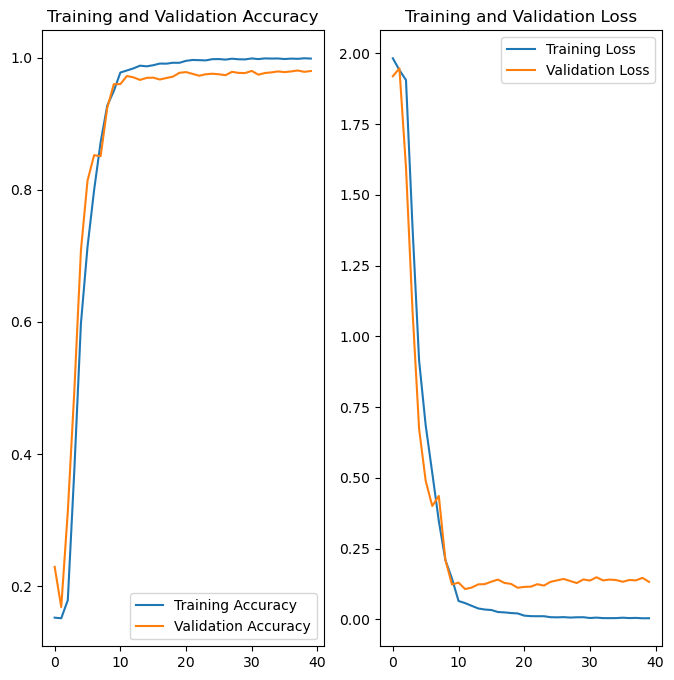

In [171]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [172]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

613/613 [==============================] - 14s 22ms/step
Confusion Matrix
[[819   3   0   0   3   0   0]
 [  1 708   0   0   0   0   0]
 [  0   0 636   0   2   4   1]
 [  0   0   0 565   1   0   0]
 [  0   0   0   0 698  15  46]
 [  0   0   5   0   2 658   0]
 [  0   0   0   0  16   0 721]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       1.00      0.99      1.00       825
      Aedes albopictus       1.00      1.00      1.00       709
          Aedes vexans       0.99      0.99      0.99       643
        An tessellatus       1.00      1.00      1.00       566
Culex quinquefasciatus       0.97      0.92      0.94       759
         Culex vishnui       0.97      0.99      0.98       665
                Others       0.94      0.98      0.96       737

              accuracy                           0.98      4904
             macro avg       0.98      0.98      0.98      4904
          weighted avg       0.98      0.9

In [173]:
model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_35 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

 conv2d_55 (Conv2D)             (None, 28, 28, 512)  1180160     ['spatial_dropout2d_18[0][0]']   
                                                                                                  
 conv2d_43 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_42[0][0]']              
                                                                                                  
 conv2d_56 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_55[0][0]']              
                                                                                                  
 conv2d_44 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_43[0][0]']              
                                                                                                  
 conv2d_57 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_56[0][0]']              
                                                                                                  
 max_pooli

Epoch 12/40
2543/2543 [==============================] - 240s 94ms/step - loss: 0.0241 - accuracy: 0.9916 - val_loss: 0.1374 - val_accuracy: 0.9688 - lr: 1.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 13/40
2543/2543 [==============================] - 247s 97ms/step - loss: 0.0228 - accuracy: 0.9921 - val_loss: 0.1241 - val_accuracy: 0.9676 - lr: 1.0000e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 14/40
2543/2543 [==============================] - 244s 96ms/step - loss: 0.0183 - accuracy: 0.9941 - val_loss: 0.1071 - val_accuracy: 0.9741 - lr: 1.0000e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 15/40
2543/2543 [==============================] - 239s 94ms/step - loss: 0.0170 - accuracy: 0.9942 - val_loss: 0.1212 - val_accuracy: 0.9708 - lr: 1.0000e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 16/40
2543

Maximum test accuracy is at 97.7 %.


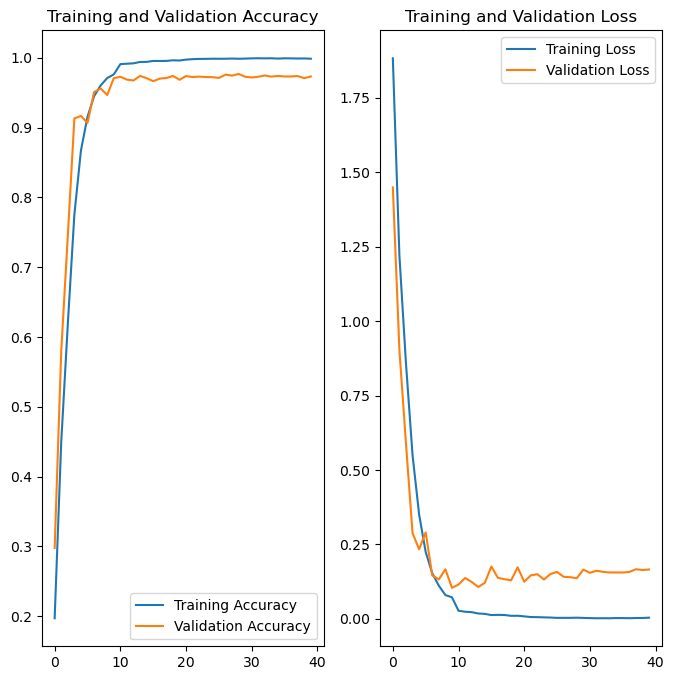

In [174]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [175]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

613/613 [==============================] - 16s 26ms/step
Confusion Matrix
[[823   2   0   0   0   0   0]
 [  0 709   0   0   0   0   0]
 [  1   0 634   2   1   5   0]
 [  0   0   0 565   0   1   0]
 [  1   0   0   0 661  26  71]
 [  0   0  12   0   4 649   0]
 [  0   0   0   0   5   0 732]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       1.00      1.00      1.00       825
      Aedes albopictus       1.00      1.00      1.00       709
          Aedes vexans       0.98      0.99      0.98       643
        An tessellatus       1.00      1.00      1.00       566
Culex quinquefasciatus       0.99      0.87      0.92       759
         Culex vishnui       0.95      0.98      0.96       665
                Others       0.91      0.99      0.95       737

              accuracy                           0.97      4904
             macro avg       0.97      0.97      0.97      4904
          weighted avg       0.97      0.9

In [176]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 13557 files belonging to 7 classes.
Found 3269 files belonging to 7 classes.
Found 13557 files belonging to 7 classes.
Found 3269 files belonging to 7 classes.
Found 13557 files belonging to 7 classes.
Found 3269 files belonging to 7 classes.


In [177]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

409/409 [==============================] - 12s 28ms/step


In [178]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
848/848 [==============================] - 4s 4ms/step - loss: 0.3108 - accuracy: 0.9200
Epoch 2/20
848/848 [==============================] - 4s 4ms/step - loss: 0.0034 - accuracy: 0.9999
Epoch 3/20
848/848 [==============================] - 4s 4ms/step - loss: 0.0012 - accuracy: 0.9999
Epoch 4/20
848/848 [==============================] - 4s 4ms/step - loss: 6.1788e-04 - accuracy: 0.9999
Epoch 5/20
848/848 [==============================] - 3s 4ms/step - loss: 3.5027e-04 - accuracy: 1.0000
Epoch 6/20
848/848 [==============================] - 3s 3ms/step - loss: 1.9258e-04 - accuracy: 1.0000
Epoch 7/20
848/848 [==============================] - 4s 4ms/step - loss: 1.1810e-04 - accuracy: 1.0000
Epoch 8/20
848/848 [==============================] - 4s 4ms/step - loss: 7.1324e-05 - accuracy: 1.0000
Epoch 9/20
848/848 [==============================] - 3s 4ms/step - loss: 4.3716e-05 - accuracy: 1.0000
Epoch 10/20
848/848 [==============================] - 3s 4ms/step - loss: 2

103/103 [==============================] - 0s 1ms/step


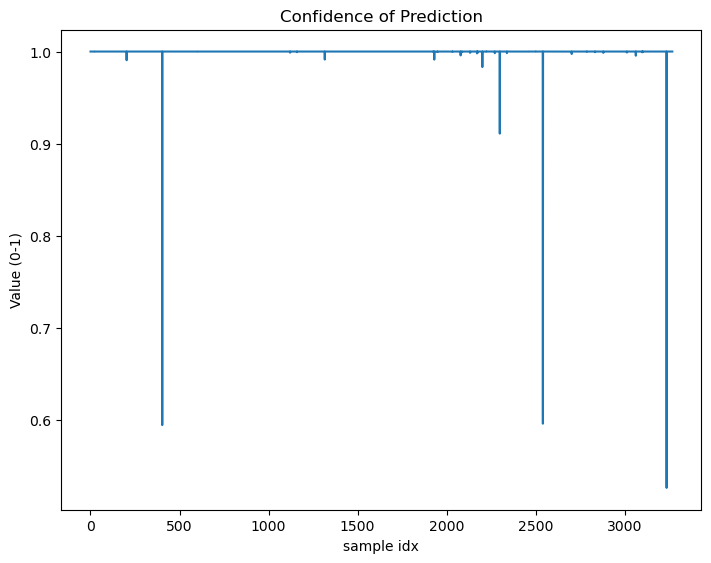

In [179]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)
#----------------------------------


In [180]:
import sys
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
tf.keras.backend.clear_session()
gc.collect()

28445

In [22]:
#---------------MODEL9-----------------------------------------#

In [23]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Culex vishnui
No. of files in Culex vishnui = 6710.
No. of files in "/tmp/tmpk0n_p2up/train/Culex vishnui/" should be around 5368.
No. of files in /tmp/tmpk0n_p2up/train/Culex vishnui/ = 5390.
No. of files in "/tmp/tmpk0n_p2up/test/Culex vishnui/" should be around 0.
No. of files in /tmp/tmpk0n_p2up/test/Culex vishnui/ = 0.
No. of files in "/tmp/tmpk0n_p2up/val/Culex vishnui/" should be around 1342.
No. of files in /tmp/tmpk0n_p2up/val/Culex vishnui/ = 1320.
Found Culex quinquefasciatus
No. of files in Culex quinquefasciatus = 7909.
No. of files in "/tmp/tmpk0n_p2up/train/Culex quinquefasciatus/" should be around 6328.
No. of files in /tmp/tmpk0n_p2up/train/Culex quinquefasciatus/ = 6347.
No. of files in "/tmp/tmpk0n_p2up/test/Culex quinquefasciatus/" should be around 0.
No. of files in /tmp/tmpk0n_p2up/test/Culex quinquefasciatus/ = 0.
No. of files in "/tmp/tmpk0n_p2up/val/Culex quinquefasciatus/" should be around 1582.
No. of files in /tmp/tmpk0n_p2up/

((20282, 4961, 0), (13520, 3306, 0))

In [24]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 20282 files belonging to 7 classes.


2022-09-24 09:17:59.687752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-24 09:18:00.460346: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22227 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Found 4961 files belonging to 7 classes.
Found 20282 files belonging to 7 classes.
Found 4961 files belonging to 7 classes.


In [25]:
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/09/24-09:18:12

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40


2022-09-24 09:18:24.497290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1466 of 2536
2022-09-24 09:18:32.022392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-09-24 09:18:33.863839: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-09-24 09:18:37.217144: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2536/2536 [==============================] - 229s 80ms/step - loss: 1.9905 - accuracy: 0.1536 - val_loss: 1.8991 - val_accuracy: 0.1887 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
2536/2536 [==============================] - 197s 78ms/step - loss: 1.7338 - accuracy: 0.2496 - val_loss: 1.4090 - val_accuracy: 0.3648 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
2536/2536 [==============================] - 194s 77ms/step - loss: 1.2404 - accuracy: 0.4473 - val_loss: 1.1858 - val_accuracy: 0.4507 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
2536/2536 [==============================] - 194s 77ms/step - loss: 0.8964 - accuracy: 0.6255 - val_loss: 0.8449 - val_accuracy: 0.6384 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/40
2536/2536 [=========

2536/2536 [==============================] - 192s 76ms/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 0.2069 - val_accuracy: 0.9573 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
2536/2536 [==============================] - 191s 76ms/step - loss: 0.0064 - accuracy: 0.9981 - val_loss: 0.2179 - val_accuracy: 0.9544 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
2536/2536 [==============================] - 192s 76ms/step - loss: 0.0071 - accuracy: 0.9974 - val_loss: 0.2652 - val_accuracy: 0.9464 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
2536/2536 [==============================] - 190s 75ms/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.2370 - val_accuracy: 0.9536 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
2536/2536 [=====

Maximum test accuracy is at 95.73 %.


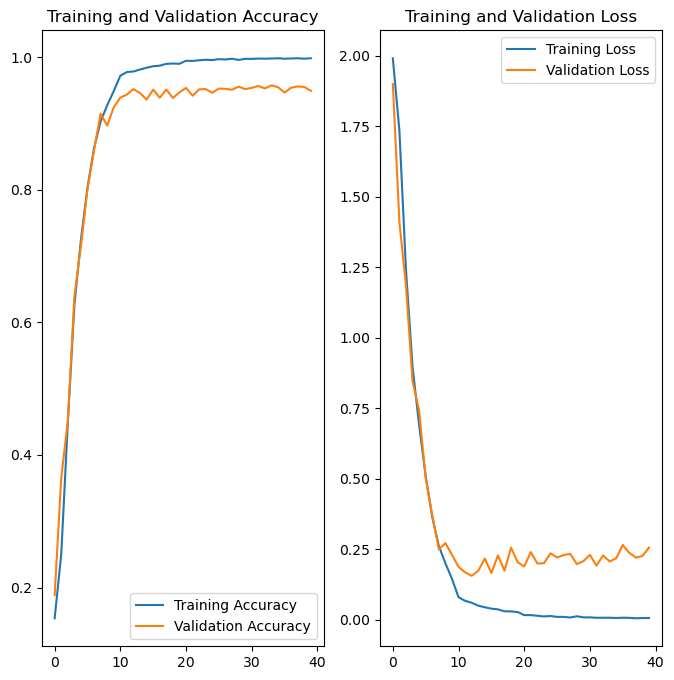

In [26]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [27]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

621/621 [==============================] - 14s 21ms/step
Confusion Matrix
[[794  28   0   1   0   1   1]
 [ 17 704   0   0   0   0   5]
 [  0   0 635   0   0   3   0]
 [  0   0   2 569   0   0   1]
 [  1   0   4   0 726  41   9]
 [  0   0  11   3  15 631   0]
 [  0   0   0   0 110   0 649]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.98      0.96      0.97       825
      Aedes albopictus       0.96      0.97      0.97       726
          Aedes vexans       0.97      1.00      0.98       638
        An tessellatus       0.99      0.99      0.99       572
Culex quinquefasciatus       0.85      0.93      0.89       781
         Culex vishnui       0.93      0.96      0.94       660
                Others       0.98      0.86      0.91       759

              accuracy                           0.95      4961
             macro avg       0.95      0.95      0.95      4961
          weighted avg       0.95      0.9

In [28]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

                                                                                                  
 spatial_dropout2d_10 (SpatialD  (None, 14, 14, 512)  0          ['max_pooling2d_10[0][0]']       
 ropout2D)                                                                                        
                                                                                                  
 conv2d_32 (Conv2D)             (None, 14, 14, 512)  2359808     ['spatial_dropout2d_10[0][0]']   
                                                                                                  
 conv2d_33 (Conv2D)             (None, 14, 14, 512)  2359808     ['conv2d_32[0][0]']              
                                                                                                  
 conv2d_34 (Conv2D)             (None, 14, 14, 512)  2359808     ['conv2d_33[0][0]']              
                                                                                                  
 max_pooli


Epoch 22: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 22/40
2536/2536 [==============================] - 223s 88ms/step - loss: 0.0055 - accuracy: 0.9981 - val_loss: 0.1274 - val_accuracy: 0.9696 - lr: 5.0000e-06

Epoch 23: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 23/40
2536/2536 [==============================] - 217s 86ms/step - loss: 0.0048 - accuracy: 0.9982 - val_loss: 0.1352 - val_accuracy: 0.9692 - lr: 5.0000e-06

Epoch 24: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 24/40
2536/2536 [==============================] - 220s 87ms/step - loss: 0.0043 - accuracy: 0.9986 - val_loss: 0.1566 - val_accuracy: 0.9675 - lr: 5.0000e-06

Epoch 25: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 25/40
2536/2536 [==============================] - 214s 84ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 0.1271 - val_accuracy: 0.9714 - lr: 5.0000e-06

Epoch 26: Learn

Maximum test accuracy is at 97.32 %.


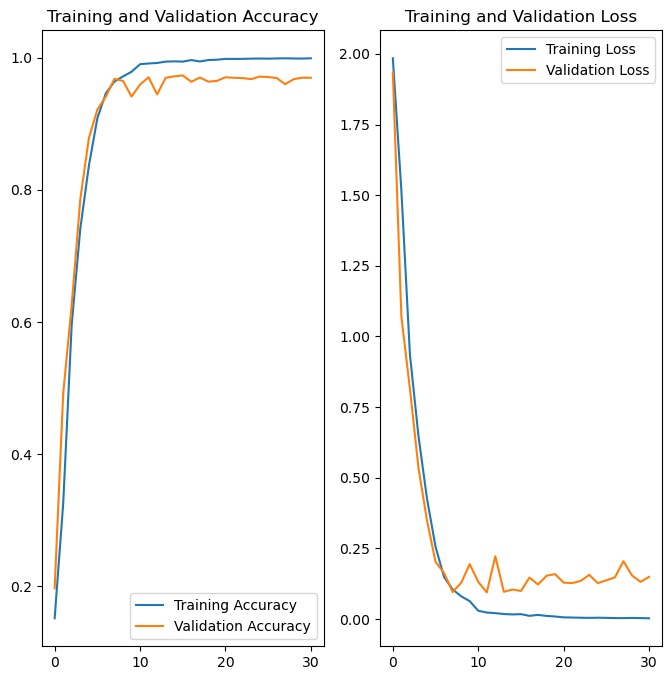

In [29]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [30]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

621/621 [==============================] - 15s 23ms/step
Confusion Matrix
[[811  14   0   0   0   0   0]
 [  7 719   0   0   0   0   0]
 [  0   0 638   0   0   0   0]
 [  0   0   0 570   0   0   2]
 [  1   1   2   0 727  45   5]
 [  0   0   2   0   4 654   0]
 [  0   0   0   0  50   0 709]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.99      0.98      0.99       825
      Aedes albopictus       0.98      0.99      0.98       726
          Aedes vexans       0.99      1.00      1.00       638
        An tessellatus       1.00      1.00      1.00       572
Culex quinquefasciatus       0.93      0.93      0.93       781
         Culex vishnui       0.94      0.99      0.96       660
                Others       0.99      0.93      0.96       759

              accuracy                           0.97      4961
             macro avg       0.97      0.98      0.97      4961
          weighted avg       0.97      0.9

In [31]:
model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_35 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

 conv2d_55 (Conv2D)             (None, 28, 28, 512)  1180160     ['spatial_dropout2d_18[0][0]']   
                                                                                                  
 conv2d_43 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_42[0][0]']              
                                                                                                  
 conv2d_56 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_55[0][0]']              
                                                                                                  
 conv2d_44 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_43[0][0]']              
                                                                                                  
 conv2d_57 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_56[0][0]']              
                                                                                                  
 max_pooli

Epoch 12/40
2536/2536 [==============================] - 247s 97ms/step - loss: 0.0163 - accuracy: 0.9944 - val_loss: 0.1243 - val_accuracy: 0.9613 - lr: 1.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 13/40
2536/2536 [==============================] - 247s 97ms/step - loss: 0.0125 - accuracy: 0.9955 - val_loss: 0.1282 - val_accuracy: 0.9643 - lr: 1.0000e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 14/40
2536/2536 [==============================] - 245s 97ms/step - loss: 0.0179 - accuracy: 0.9940 - val_loss: 0.1320 - val_accuracy: 0.9611 - lr: 1.0000e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 15/40
2536/2536 [==============================] - 249s 98ms/step - loss: 0.0096 - accuracy: 0.9968 - val_loss: 0.1174 - val_accuracy: 0.9690 - lr: 1.0000e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 16/40
2536

Maximum test accuracy is at 97.8 %.


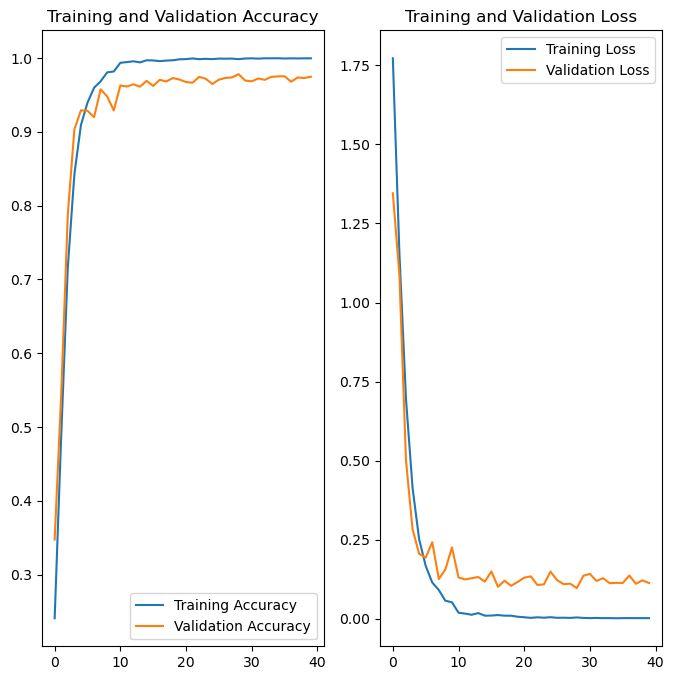

In [32]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [33]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

621/621 [==============================] - 17s 27ms/step
Confusion Matrix
[[811  14   0   0   0   0   0]
 [  8 718   0   0   0   0   0]
 [  0   0 638   0   0   0   0]
 [  0   0   1 569   0   2   0]
 [  0   1   0   0 740  27  13]
 [  0   0   4   0   2 654   0]
 [  0   0   0   0  54   0 705]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.99      0.98      0.99       825
      Aedes albopictus       0.98      0.99      0.98       726
          Aedes vexans       0.99      1.00      1.00       638
        An tessellatus       1.00      0.99      1.00       572
Culex quinquefasciatus       0.93      0.95      0.94       781
         Culex vishnui       0.96      0.99      0.97       660
                Others       0.98      0.93      0.95       759

              accuracy                           0.97      4961
             macro avg       0.98      0.98      0.98      4961
          weighted avg       0.97      0.9

In [34]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 13520 files belonging to 7 classes.
Found 3306 files belonging to 7 classes.
Found 13520 files belonging to 7 classes.
Found 3306 files belonging to 7 classes.
Found 13520 files belonging to 7 classes.
Found 3306 files belonging to 7 classes.


In [35]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

414/414 [==============================] - 12s 28ms/step


In [36]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
845/845 [==============================] - 3s 4ms/step - loss: 0.2854 - accuracy: 0.9348
Epoch 2/20
845/845 [==============================] - 3s 4ms/step - loss: 0.0034 - accuracy: 0.9999
Epoch 3/20
845/845 [==============================] - 3s 4ms/step - loss: 0.0011 - accuracy: 0.9999
Epoch 4/20
845/845 [==============================] - 3s 4ms/step - loss: 5.0150e-04 - accuracy: 0.9999
Epoch 5/20
845/845 [==============================] - 3s 4ms/step - loss: 2.8679e-04 - accuracy: 1.0000
Epoch 6/20
845/845 [==============================] - 3s 4ms/step - loss: 1.7452e-04 - accuracy: 1.0000
Epoch 7/20
845/845 [==============================] - 3s 4ms/step - loss: 1.0778e-04 - accuracy: 1.0000
Epoch 8/20
845/845 [==============================] - 3s 4ms/step - loss: 7.1089e-05 - accuracy: 1.0000
Epoch 9/20
845/845 [==============================] - 3s 4ms/step - loss: 4.7040e-05 - accuracy: 1.0000
Epoch 10/20
845/845 [==============================] - 3s 4ms/step - loss: 3

104/104 [==============================] - 0s 2ms/step


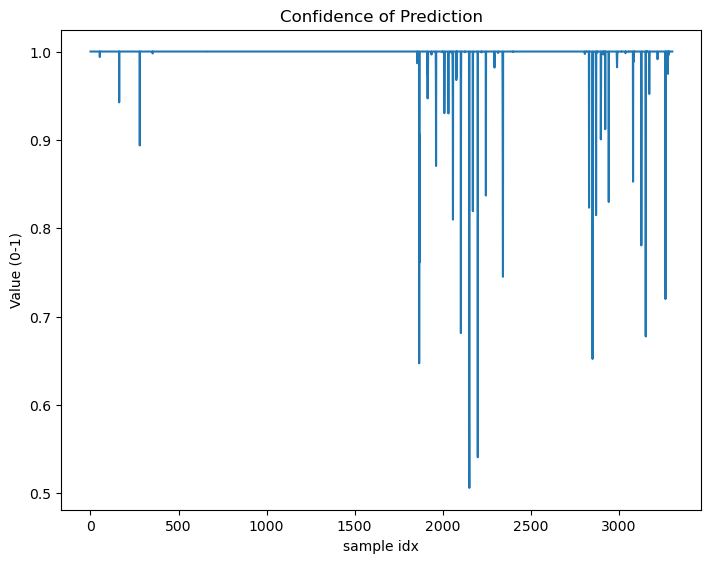

In [37]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)
#----------------------------------


In [38]:
import sys
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
tf.keras.backend.clear_session()
gc.collect()

34315

In [39]:
#---------------MODEL 10-----------------------------------------#

In [40]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Culex vishnui
No. of files in Culex vishnui = 6710.
No. of files in "/tmp/tmp9_eas32q/train/Culex vishnui/" should be around 5368.
No. of files in /tmp/tmp9_eas32q/train/Culex vishnui/ = 5423.
No. of files in "/tmp/tmp9_eas32q/test/Culex vishnui/" should be around 0.
No. of files in /tmp/tmp9_eas32q/test/Culex vishnui/ = 0.
No. of files in "/tmp/tmp9_eas32q/val/Culex vishnui/" should be around 1342.
No. of files in /tmp/tmp9_eas32q/val/Culex vishnui/ = 1287.
Found Culex quinquefasciatus
No. of files in Culex quinquefasciatus = 7909.
No. of files in "/tmp/tmp9_eas32q/train/Culex quinquefasciatus/" should be around 6328.
No. of files in /tmp/tmp9_eas32q/train/Culex quinquefasciatus/ = 6391.
No. of files in "/tmp/tmp9_eas32q/test/Culex quinquefasciatus/" should be around 0.
No. of files in /tmp/tmp9_eas32q/test/Culex quinquefasciatus/ = 0.
No. of files in "/tmp/tmp9_eas32q/val/Culex quinquefasciatus/" should be around 1582.
No. of files in /tmp/tmp9_eas32q/

((20369, 4871, 0), (13578, 3247, 0))

In [41]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 20369 files belonging to 7 classes.
Found 4871 files belonging to 7 classes.
Found 20369 files belonging to 7 classes.
Found 4871 files belonging to 7 classes.


In [42]:
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/09/24-16:25:35

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40


2022-09-24 16:25:47.078891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1597 of 2547


   3/2547 [..............................] - ETA: 2:42 - loss: 4.1502 - accuracy: 0.0417  

2022-09-24 16:25:53.095402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


2547/2547 [==============================] - 207s 74ms/step - loss: 2.0045 - accuracy: 0.1499 - val_loss: 1.9542 - val_accuracy: 0.1558 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
2547/2547 [==============================] - 185s 73ms/step - loss: 1.7282 - accuracy: 0.2515 - val_loss: 1.3116 - val_accuracy: 0.4192 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
2547/2547 [==============================] - 179s 70ms/step - loss: 1.2217 - accuracy: 0.4488 - val_loss: 0.9335 - val_accuracy: 0.5869 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
2547/2547 [==============================] - 183s 72ms/step - loss: 0.8954 - accuracy: 0.6246 - val_loss: 0.7189 - val_accuracy: 0.6972 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/40
2547/2547 [=========

2547/2547 [==============================] - 175s 69ms/step - loss: 0.0064 - accuracy: 0.9980 - val_loss: 0.0718 - val_accuracy: 0.9815 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
2547/2547 [==============================] - 180s 71ms/step - loss: 0.0052 - accuracy: 0.9982 - val_loss: 0.0767 - val_accuracy: 0.9813 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
2547/2547 [==============================] - 179s 70ms/step - loss: 0.0057 - accuracy: 0.9980 - val_loss: 0.0679 - val_accuracy: 0.9811 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
2547/2547 [==============================] - 175s 69ms/step - loss: 0.0046 - accuracy: 0.9985 - val_loss: 0.0711 - val_accuracy: 0.9823 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
2547/2547 [=====

Maximum test accuracy is at 98.3 %.


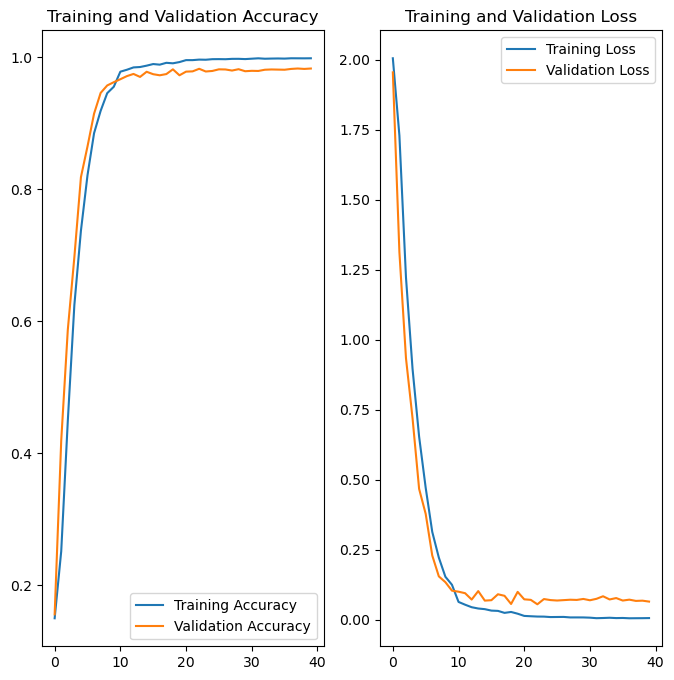

In [43]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [44]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

609/609 [==============================] - 13s 21ms/step
Confusion Matrix
[[771  35   0   0   1   0   1]
 [ 12 697   0   0   0   0   0]
 [  0   0 635   0   2   1   0]
 [  0   0   1 582   0   0   0]
 [  1   0   0   0 741   6  11]
 [  1   0   3   1   3 635   0]
 [  0   3   0   0   1   0 727]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.98      0.95      0.97       808
      Aedes albopictus       0.95      0.98      0.97       709
          Aedes vexans       0.99      1.00      0.99       638
        An tessellatus       1.00      1.00      1.00       583
Culex quinquefasciatus       0.99      0.98      0.98       759
         Culex vishnui       0.99      0.99      0.99       643
                Others       0.98      0.99      0.99       731

              accuracy                           0.98      4871
             macro avg       0.98      0.98      0.98      4871
          weighted avg       0.98      0.9

In [45]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

                                                                                                  
 spatial_dropout2d_10 (SpatialD  (None, 14, 14, 512)  0          ['max_pooling2d_10[0][0]']       
 ropout2D)                                                                                        
                                                                                                  
 conv2d_32 (Conv2D)             (None, 14, 14, 512)  2359808     ['spatial_dropout2d_10[0][0]']   
                                                                                                  
 conv2d_33 (Conv2D)             (None, 14, 14, 512)  2359808     ['conv2d_32[0][0]']              
                                                                                                  
 conv2d_34 (Conv2D)             (None, 14, 14, 512)  2359808     ['conv2d_33[0][0]']              
                                                                                                  
 max_pooli


Epoch 22: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 22/40
2547/2547 [==============================] - 211s 83ms/step - loss: 0.0092 - accuracy: 0.9970 - val_loss: 0.0447 - val_accuracy: 0.9838 - lr: 5.0000e-06

Epoch 23: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 23/40
2547/2547 [==============================] - 211s 83ms/step - loss: 0.0052 - accuracy: 0.9982 - val_loss: 0.0335 - val_accuracy: 0.9875 - lr: 5.0000e-06

Epoch 24: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 24/40
2547/2547 [==============================] - 211s 83ms/step - loss: 0.0064 - accuracy: 0.9978 - val_loss: 0.0373 - val_accuracy: 0.9871 - lr: 5.0000e-06

Epoch 25: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 25/40
2547/2547 [==============================] - 209s 82ms/step - loss: 0.0061 - accuracy: 0.9979 - val_loss: 0.0317 - val_accuracy: 0.9883 - lr: 5.0000e-06

Epoch 26: Learn

Maximum test accuracy is at 98.99 %.


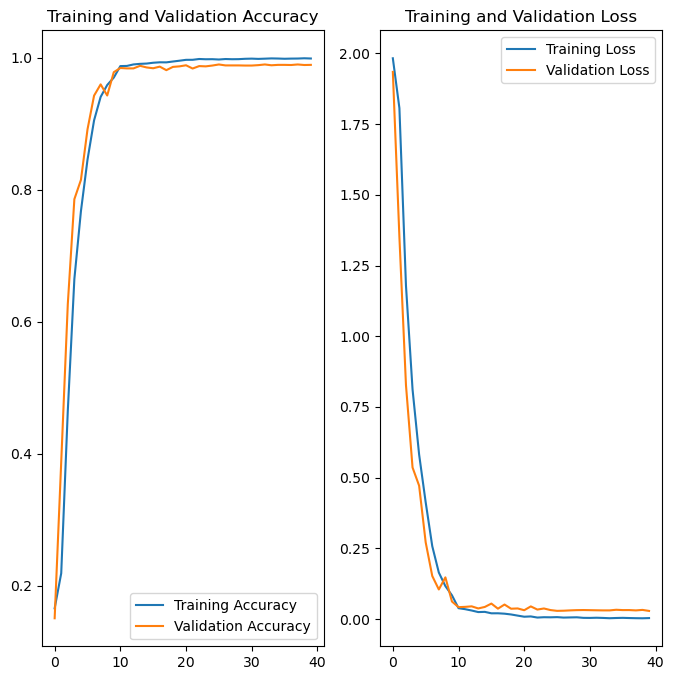

In [46]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [47]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

609/609 [==============================] - 15s 24ms/step
Confusion Matrix
[[795  13   0   0   0   0   0]
 [ 15 694   0   0   0   0   0]
 [  0   0 637   0   0   1   0]
 [  1   0   0 582   0   0   0]
 [  2   0   0   0 745   4   8]
 [  0   0   1   0   3 639   0]
 [  0   1   0   0   3   0 727]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.98      0.98      0.98       808
      Aedes albopictus       0.98      0.98      0.98       709
          Aedes vexans       1.00      1.00      1.00       638
        An tessellatus       1.00      1.00      1.00       583
Culex quinquefasciatus       0.99      0.98      0.99       759
         Culex vishnui       0.99      0.99      0.99       643
                Others       0.99      0.99      0.99       731

              accuracy                           0.99      4871
             macro avg       0.99      0.99      0.99      4871
          weighted avg       0.99      0.9

In [ ]:
model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_35 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

 conv2d_55 (Conv2D)             (None, 28, 28, 512)  1180160     ['spatial_dropout2d_18[0][0]']   
                                                                                                  
 conv2d_43 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_42[0][0]']              
                                                                                                  
 conv2d_56 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_55[0][0]']              
                                                                                                  
 conv2d_44 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_43[0][0]']              
                                                                                                  
 conv2d_57 (Conv2D)             (None, 28, 28, 512)  2359808     ['conv2d_56[0][0]']              
                                                                                                  
 max_pooli

Epoch 12/40
2547/2547 [==============================] - 250s 98ms/step - loss: 0.0142 - accuracy: 0.9950 - val_loss: 0.0698 - val_accuracy: 0.9752 - lr: 1.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 13/40
2547/2547 [==============================] - 251s 98ms/step - loss: 0.0122 - accuracy: 0.9959 - val_loss: 0.0376 - val_accuracy: 0.9867 - lr: 1.0000e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 14/40
2547/2547 [==============================] - 246s 97ms/step - loss: 0.0107 - accuracy: 0.9964 - val_loss: 0.0433 - val_accuracy: 0.9846 - lr: 1.0000e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 15/40
2547/2547 [==============================] - 246s 97ms/step - loss: 0.0132 - accuracy: 0.9952 - val_loss: 0.0323 - val_accuracy: 0.9883 - lr: 1.0000e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 16/40
2547

In [ ]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [ ]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

In [ ]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

In [ ]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

In [ ]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

In [ ]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)
#----------------------------------


In [ ]:
#---------------MODEL 11-----------------------------------------#

split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------
ensemble.evaluate(Yh_val,Y_val)
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)

In [ ]:
#---------------MODEL 11-----------------------------------------#

split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------
ensemble.evaluate(Yh_val,Y_val)
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)